# <center>Organizaci&oacute;n de Datos</center>
#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>

## <center>Trabajo Práctico 1 : Propiedades en Venta</center>
## <center>Parte 1</center>
### <center> Grupo 22 </center>
### <center> Integrantes: </center>
##### <center> Federico Martin Forte,  Francisco Sobral,  Ian Klaus von der Heyde,  Juan Pablo Aschieri,  Joaquin Rivero  </center>

# Carga de Datos y librerías

In [142]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('always')
from sklearn.model_selection import train_test_split

import shapely.speedups
from shapely.ops import cascaded_union

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from IPython.display import Image

import geopandas as gp

In [143]:
dataset=pd.read_csv('./Datasets/properati_argentina_2021.csv').copy()

##### Dataset de barrios proporcionado por el gobierno de la ciudad, link: https://data.buenosaires.gob.ar/dataset/barrios/resource/1c3d185b-fdc9-474b-b41b-9bd960a3806e

Agregamos "apodos" comunes y tildes al poly.

In [144]:
poly = gp.read_file(r'./Datasets/barrios.geojson')
#APODOS
once = poly[poly.BARRIO == 'BALVANERA'].copy()
once.loc[:,'BARRIO'] = 'ONCE'
congreso = poly[poly.BARRIO == 'BALVANERA'].copy()
congreso.loc[:,'BARRIO'] = 'CONGRESO'
tribunales = poly[poly.BARRIO == 'SAN NICOLAS'].copy()
tribunales.loc[:,'BARRIO'] = 'TRIBUNALES'
barrio_norte = poly[poly.BARRIO == 'RETIRO'].copy()
barrio_norte.loc[:,'BARRIO'] = 'BARRIO NORTE'
abasto = poly[poly.BARRIO == 'PALERMO'].copy()
abasto.loc[:,'BARRIO'] = 'ABASTO'
pompeya = poly[poly.BARRIO == 'NUEVA POMPEYA'].copy()
pompeya.loc[:,'BARRIO'] = 'POMPEYA'
#TILDES
poly.loc[poly.BARRIO == 'SAN NICOLAS', 'BARRIO'] = 'SAN NICOLÁS'
poly.loc[poly.BARRIO == 'CONSTITUCION', 'BARRIO'] = 'CONSTITUCIÓN'
poly.loc[poly.BARRIO == 'VILLA PUEYRREDON', 'BARRIO'] = 'VILLA PUEYRREDÓN'
poly.loc[poly.BARRIO == 'VILLA GRAL. MITRE', 'BARRIO'] = 'VILLA GENERAL MITRE'
poly.loc[poly.BARRIO == 'AGRONOMIA', 'BARRIO'] = 'AGRONOMÍA'

poly = pd.concat([poly,once,congreso,tribunales, barrio_norte, abasto, pompeya]).reset_index(drop=True)
poly.to_file('./Datasets/barrios_procesados.geojson', driver="GeoJSON")  

# 1. Análisis Exploratorio y Preprocesamiento de Datos

### Exploración Inicial :

##### Primer análisis y seleccionamento de datos:

In [145]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460154 entries, 0 to 460153
Data columns (total 20 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   id                        460154 non-null  object 
 1   start_date                460154 non-null  object 
 2   end_date                  460154 non-null  object 
 3   created_on                460154 non-null  object 
 4   latitud                   419740 non-null  float64
 5   longitud                  419740 non-null  float64
 6   place_l2                  460154 non-null  object 
 7   place_l3                  437665 non-null  object 
 8   place_l4                  139020 non-null  object 
 9   place_l5                  2430 non-null    object 
 10  place_l6                  0 non-null       float64
 11  operation                 460154 non-null  object 
 12  property_type             460154 non-null  object 
 13  property_rooms            368498 non-null  f

Se puede observar que el presente dataset contiene 460154 filas y 20 columnas.  
Las variables cuantitativas que se pueden apreciar son :  

+ Latitud
+ Longitud
+ Property Rooms
+ Property Bedrooms
+ Property Surface Total
+ Property Surface Covered
+ Property Price  

Las variables cualitativas que se pueden apreciar son :
+ Id
+ Start Date
+ End Date
+ Created On
+ Todas las Place (l2, l3, l4, l5 y l6)
+ Operation
+ Property Type
+ Property Currency
+ Property Title  

En nuestro caso, vamos a quedarnos unicamente con las viviendas (Casa, PH, Departamento) en venta ubicadas en CABA cuyo precio esta en dólares.  
A su vez, analizamos la misma de manera analoga al dataset anterior.

In [146]:
viviendas = dataset[dataset.property_type.isin(['Casa', 'PH', 'Departamento'])].copy() 
viviendas_caba= viviendas[(viviendas.place_l2 == 'Capital Federal') & (viviendas.operation == 'Venta') & (viviendas.property_currency == 'USD')].copy()

Volvemos a analizar el nuevo dataset.

In [147]:
viviendas_caba.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94249 entries, 25 to 460090
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        94249 non-null  object 
 1   start_date                94249 non-null  object 
 2   end_date                  94249 non-null  object 
 3   created_on                94249 non-null  object 
 4   latitud                   90519 non-null  float64
 5   longitud                  90519 non-null  float64
 6   place_l2                  94249 non-null  object 
 7   place_l3                  93832 non-null  object 
 8   place_l4                  3643 non-null   object 
 9   place_l5                  0 non-null      object 
 10  place_l6                  0 non-null      float64
 11  operation                 94249 non-null  object 
 12  property_type             94249 non-null  object 
 13  property_rooms            93205 non-null  float64
 14  prop

Vemos que ahora tenemos 94249 filas y 20 columnas.  
A su vez, observamos que `place_l5` y `place_l6` tienen todos valores nulos.  
Por sus nombres, sospechamos que `start_date` y `created_on` son columnas que tienen los mismos datos, asi que precedemos a corroborarlos

In [148]:
viviendas_caba[viviendas_caba.start_date != viviendas_caba.created_on].shape

(0, 20)

Vemos que nos devuelve 0 filas, por lo cual es redundate tener dos filas igual.  
Procedemos a eliminar las columnas redundantes y vacias o que no nos sirven para nuestro analisis:
+ La columna `created_on` es identica a `start_date`
+ Las columnas `place_l2`, `operation` y `property_currency` ya no son útiles ya que sus valores son todos identicos por la operatoria realizada.
+ La columna `id` no nos aporta informaciión útil
+ Las columnas `place_l5` y `place_l6` estan vacias


In [149]:
viviendas_caba.drop(columns=['created_on', 'place_l2', 'operation', 'property_currency', 'place_l5', 'place_l6', 'id'], inplace=True)
viviendas_caba.head()

start_date    end_date    latitud   longitud place_l3 place_l4  \
25  2021-09-09  2021-09-26        NaN        NaN      NaN      NaN   
42  2021-09-09  2021-09-26 -34.637319 -58.361124     Boca      NaN   
43  2021-09-09  2021-09-28 -34.628647 -58.361871     Boca      NaN   
49  2021-09-09  2022-01-05 -34.610027 -58.401934     Once      NaN   
51  2021-09-09  2022-03-09 -34.631621 -58.416825    Boedo      NaN   

   property_type  property_rooms  property_bedrooms  property_surface_total  \
25          Casa             4.0                3.0                   171.0   
42  Departamento             3.0                2.0                    58.0   
43  Departamento             4.0                3.0                    70.0   
49  Departamento             4.0                2.0                     NaN   
51            PH             4.0                2.0                     NaN   

    property_surface_covered  property_price  \
25                     133.0        210000.0   
42                      55.0         82900.0   
43                      70.0         99000.0   
49                     104.0        146000.0   
51                      73.0        250000.0   

                                 property_title  
25  VENTA CASA LLAVE EN MANO - COSTA ESMERALDA   
42       VENTA TRES AMBIENTES LA BOCA PISO ALTO  
43   Departamento - 4 Ambientes - Catalinas Sur  
49          Venta departamento 4 ambientes Once  
51                                   PH - Boedo

Vemos que `place_l3` tiene barrios de CABA como valores y `place_l4` tiene vecindades de esos barrios, por lo cual procedemos a renombrarlos

In [150]:
columnas={"place_l3":"barrio", 'place_l4':'vecindad'}
viviendas_caba.rename(columns = columnas, inplace = True)

Convertimos a fecha las columnas `start_date` y `end_date`.  
Aclaramos que decidimos reeplazar la fecha de publicaciones no finalizadas por la fecha '2200-12-31' por cuestiones de implementacion de la funcion to_datetime

In [151]:
viviendas_caba.loc[:,"end_date"].replace(to_replace='9999-12-31',value='2200-12-31',inplace=True)
viviendas_caba['start_date'] = pd.to_datetime(viviendas_caba['start_date'], format='%Y/%m/%d %H:%M:%S.%f')
viviendas_caba['end_date'] = pd.to_datetime(viviendas_caba['end_date'], format='%Y/%m/%d %H:%M:%S.%f')

##### Separamos en train-test

Antes de empesar con el preprocesamiento dividimos el dataset en entrenamiento y prueba.
En este caso vamos a entrenar utilizando el 80% de los datos y validando los modelos sobre el 20% de datos restantes.

In [152]:
viviendas_caba_train, viviendas_caba_test = train_test_split(viviendas_caba, test_size=0.2, random_state=2)

Creamos copia del dataset para ir viendo los cambios gráficamente

In [153]:
viviendas_caba_train_copy = viviendas_caba.copy()

##### Análisis medidas de resumen de variables cuantitativas:

In [154]:
medidas_de_resumen = viviendas_caba_train.describe()
medidas_de_resumen.drop(['count' , 'std', 'min', 'max'], axis=0, inplace=True)
moda = viviendas_caba_train.mode()
moda.head(10)
moda.index = ['mode']

moda.drop(['barrio', 'vecindad','property_type','property_title'], axis = 1, inplace = True) 

medidas_de_resumen = pd.concat([medidas_de_resumen, moda])
medidas_de_resumen

latitud   longitud  property_rooms  property_bedrooms  \
mean -34.591125 -58.450693        2.822798           2.015567   
25%  -34.615979 -58.466523        2.000000           1.000000   
50%  -34.595749 -58.439042        3.000000           2.000000   
75%  -34.577395 -58.408935        4.000000           3.000000   
mode -34.541250 -58.472966        3.000000           1.000000   

      property_surface_total  property_surface_covered  property_price  \
mean               112.53916                 90.110213   227331.542381   
25%                 45.00000                 40.000000    95000.000000   
50%                 65.00000                 57.000000   144000.000000   
75%                105.00000                 89.000000   235000.000000   
mode                50.00000                 40.000000   110000.000000   

     start_date   end_date  
mean        NaT        NaT  
25%         NaT        NaT  
50%         NaT        NaT  
75%         NaT        NaT  
mode 2021-12-16 2021-06-05

##### Análisis gráfico distribucion de variables cuantitativas:

In [155]:
"""pairplot_fig = sns.pairplot(viviendas_caba_train, hue='property_type').figure
pairplot_fig.savefig('./Figures/paiplot')"""

"pairplot_fig = sns.pairplot(viviendas_caba_train, hue='property_type').figure\npairplot_fig.savefig('./Figures/paiplot')"

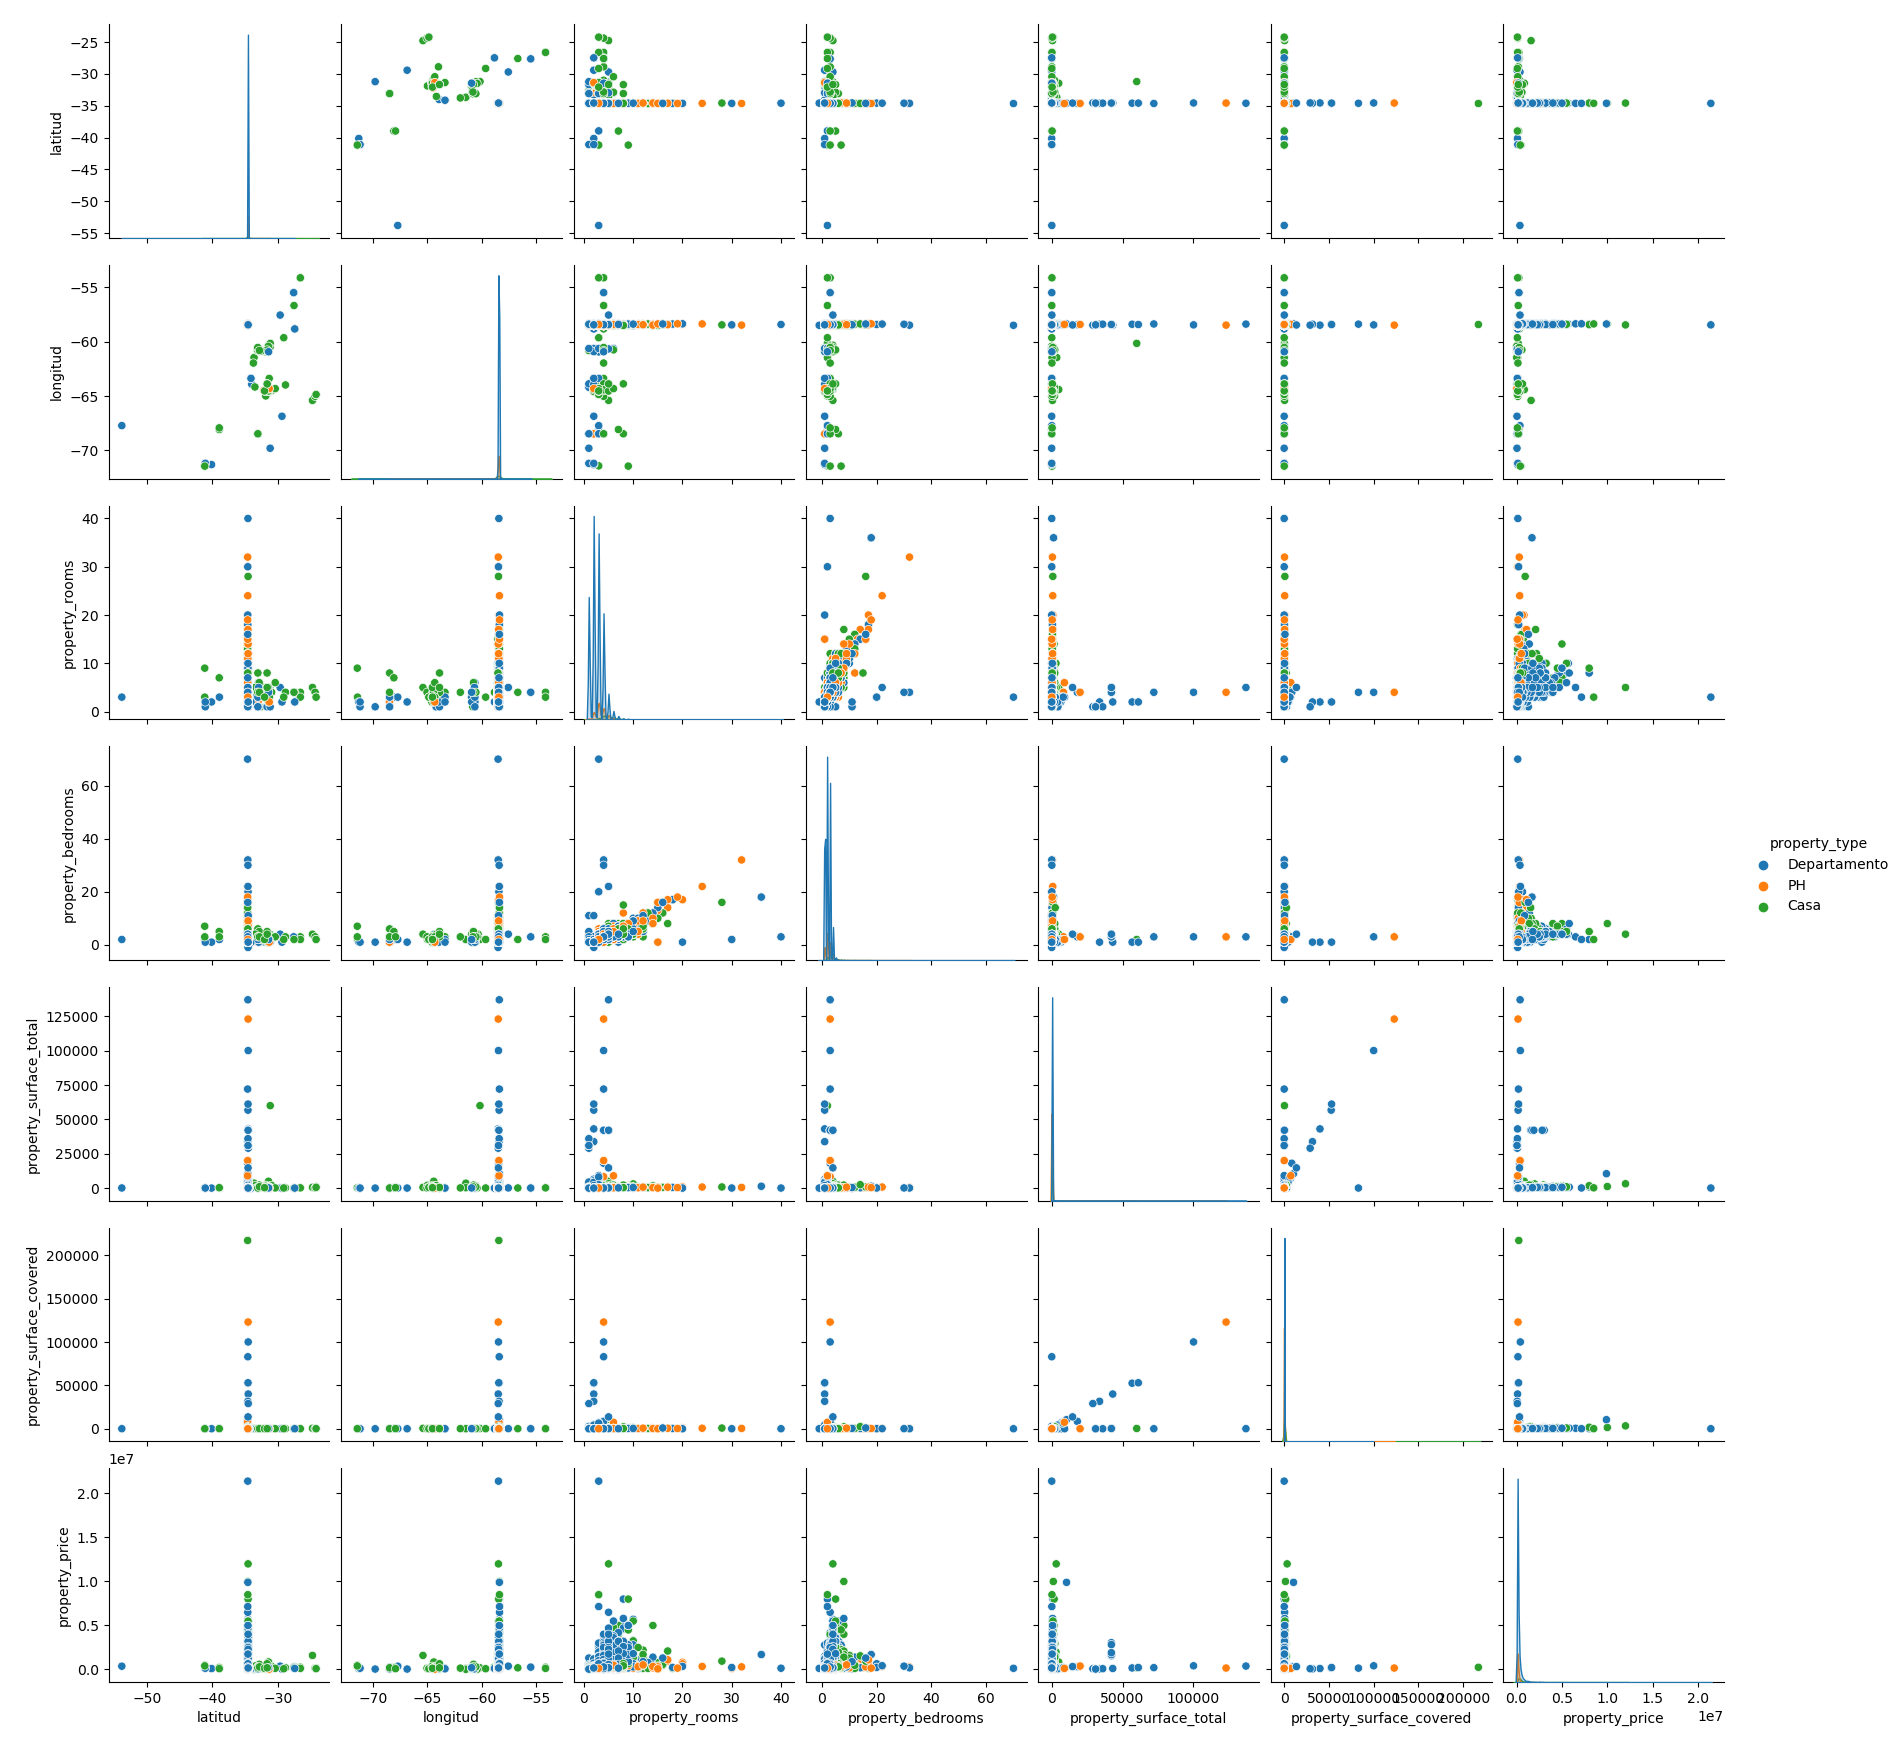

In [156]:
Image(filename = './Figures/paiplot.png', width=1500, height=1500)

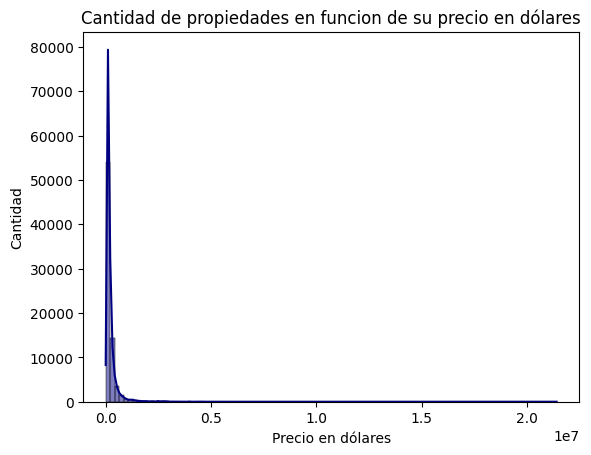

In [157]:
sns_hist = sns.histplot(data=viviendas_caba_train['property_price'], color='navy', kde=True, alpha = 0.5, bins=100).set(title="Cantidad de propiedades en funcion de su precio en dólares",xlabel="Precio en dólares",ylabel="Cantidad")

Entre otras cosas, podemos ver que hay precios muy elevados que se alejan de lo habitual

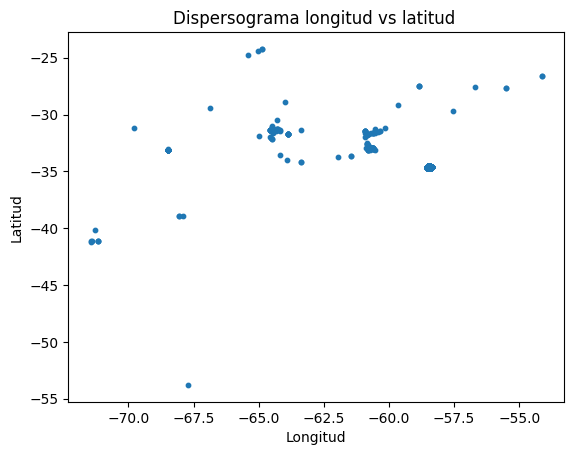

In [158]:
grf_long_lat=viviendas_caba_train.plot.scatter(x="longitud", y="latitud", s=10).set(title="Dispersograma longitud vs latitud ",xlabel='Longitud',ylabel='Latitud')

Aqui ya se puede observar que hay puntos que no estan dentro de la latitud y longitud de caba, es decir outliers que tendremos que procesar    

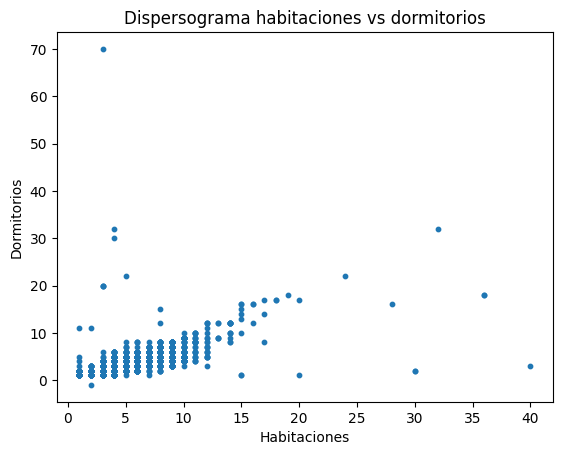

In [159]:
grf_dormitorios_por_habitaciones=viviendas_caba_train.plot.scatter(x="property_rooms", y="property_bedrooms", s=10).set(title="Dispersograma habitaciones vs dormitorios",xlabel='Habitaciones',ylabel='Dormitorios') 

Se puede observar tambien que hay algunas propiedades que tienen mas dormitorios que habitaciones, es decir, estan por encima de la diagonal del grafico anterior.

In [160]:
def ventas_por_mes(fila):
    return viviendas_caba_train.loc[fila].end_date.month

cantidad_de_ventas_por_mes = viviendas_caba_train.end_date.groupby(by=ventas_por_mes).count()

<AxesSubplot: title={'center': 'Cantidad de ventas por mes'}, xlabel='Mes', ylabel='Cantidad de ventas'>

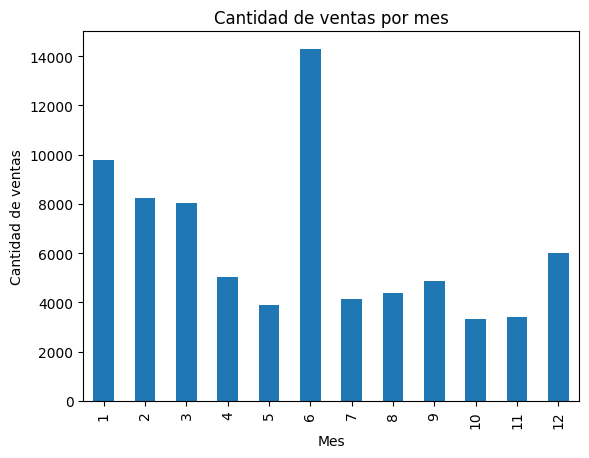

In [161]:
cantidad_de_ventas_por_mes.plot.bar(title="Cantidad de ventas por mes" , xlabel="Mes" , ylabel="Cantidad de ventas")

Vemos que Junio fue el mes con mayor numero de ventas.

<AxesSubplot: title={'center': 'Ventas por mes'}, xlabel='Mes', ylabel='Dólares'>

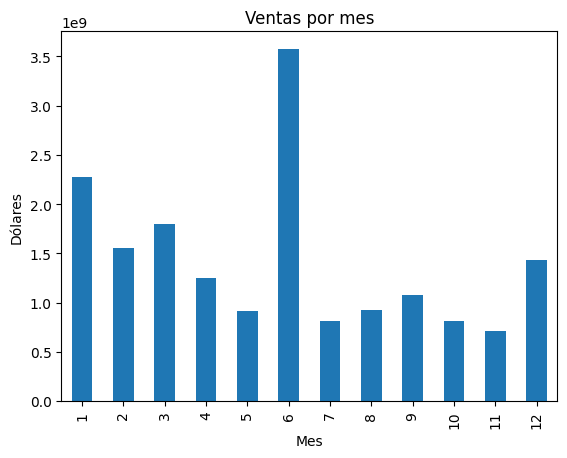

In [162]:
ventas_por_mes = viviendas_caba_train.groupby(by=ventas_por_mes).property_price.sum()

ventas_por_mes.plot.bar(title="Ventas por mes" , xlabel="Mes" , ylabel="Dólares")

Vemos que el grafico tiene una gran correlacion con el de cantidad de ventas por mes, lo cual tiene sentido.

<AxesSubplot: title={'center': 'Cantidad de viviendas por barrio'}, xlabel='Barrio', ylabel='Cantidad'>

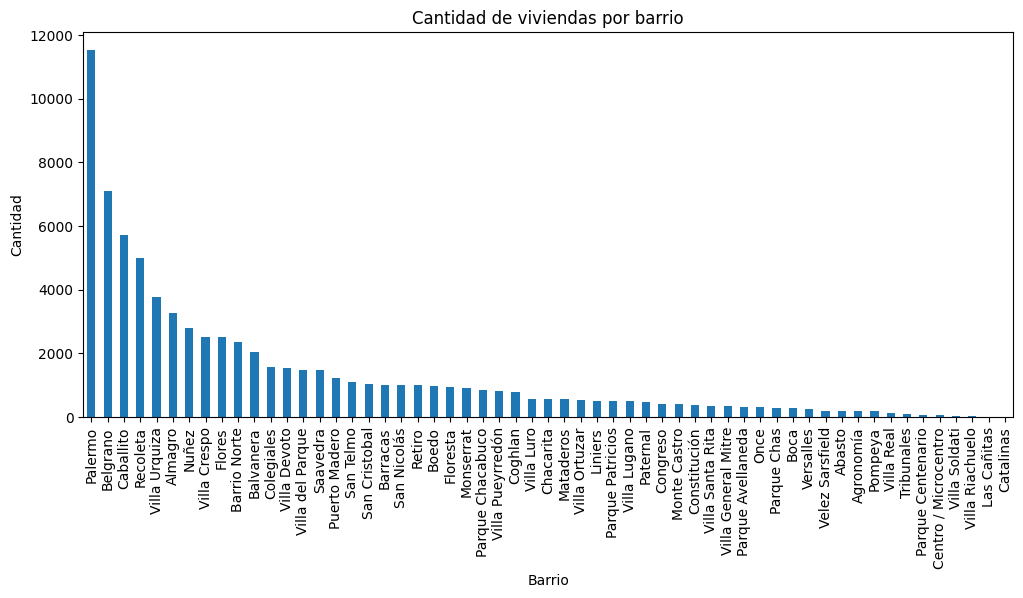

In [163]:
viviendas_caba_train.barrio.value_counts().plot.bar(figsize=(12,5),title="Cantidad de viviendas por barrio" , xlabel="Barrio" , ylabel="Cantidad")

<AxesSubplot: title={'center': 'Cantidad de viviendas por vecindario'}, xlabel='Vecindario', ylabel='Cantidad'>

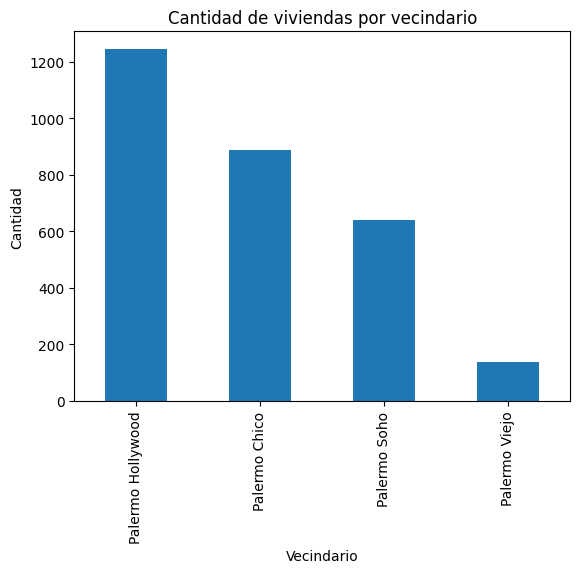

In [164]:
viviendas_caba_train.vecindad.value_counts().plot.bar(title="Cantidad de viviendas por vecindario" , xlabel="Vecindario" , ylabel="Cantidad")

Se puede observar que solamente el barrio de Palermo tiene vecindarios cargados por lo que tenemos que tomar una decisión.  
O los consideramos a todos como Palermo ,o en vez de considerar 58 barrios consieramos 63 barrios y sacamos las vecindades y los metemos en los barrios.

<AxesSubplot: title={'center': 'Promedio de precios por barrio'}, xlabel='Barrio', ylabel='Promedio de precios'>

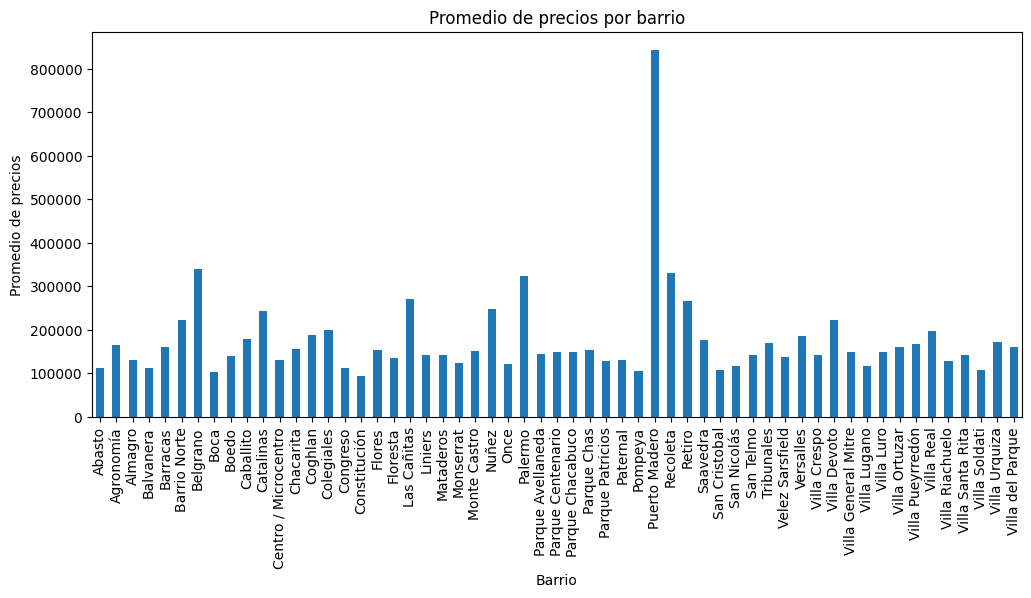

In [165]:
viviendas_caba_train.groupby('barrio')['property_price'].mean().plot.bar(figsize=(12,5), title="Promedio de precios por barrio" , xlabel="Barrio" , ylabel="Promedio de precios")

A simple vista pareciera que hay barrios mas caros que otros. Se puede ver tambien que el barrio mas caro (por lejos) es Puerto Madero, lo que es coincidente con la realidad.

<AxesSubplot: title={'center': 'Promedio de superficie total por por barrio'}, xlabel='Barrio', ylabel='Promedio de superfiecie total'>

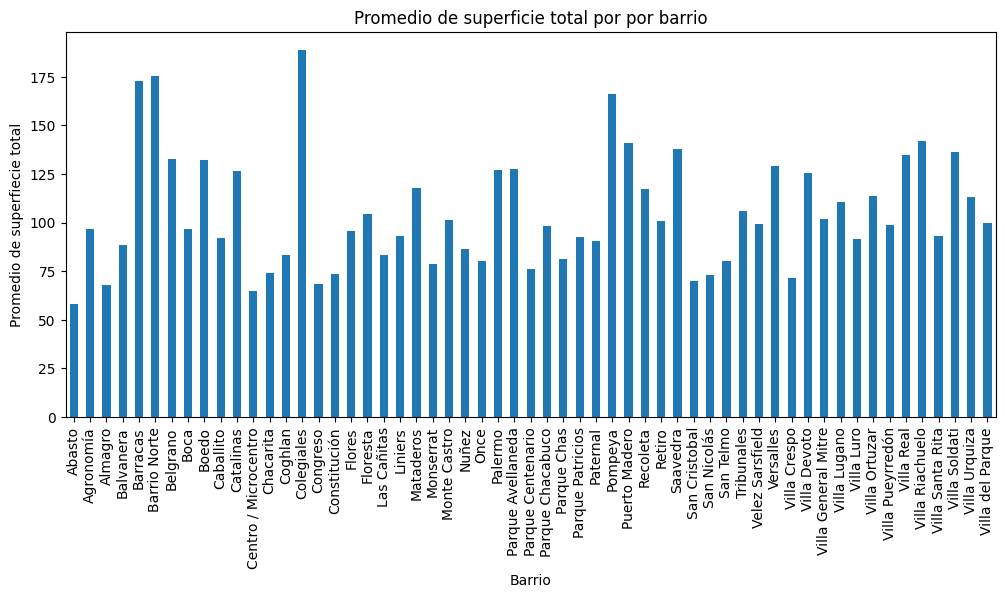

In [166]:
viviendas_caba_train.groupby('barrio')['property_surface_total'].mean().plot.bar(figsize=(12,5), title="Promedio de superficie total por por barrio" , xlabel="Barrio" , ylabel="Promedio de superfiecie total")

Vemos que en cuanto tamaño hay una distribucion bastante pareja.

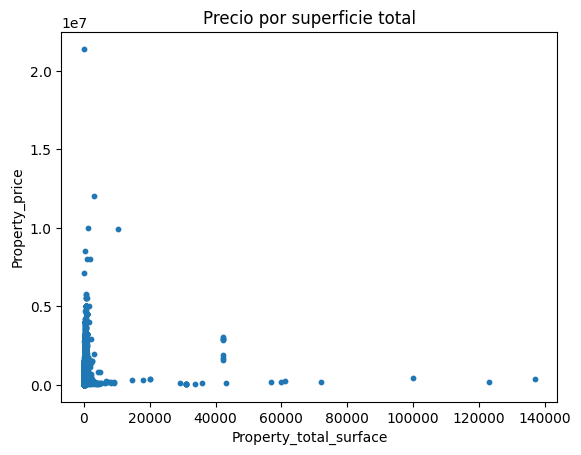

In [167]:
grf_precio_por_superficie=viviendas_caba_train.plot.scatter(x="property_surface_total", y="property_price", s=10).set(title="Precio por superficie total",xlabel='Property_total_surface',ylabel='Property_price') 

Con este grafico ya podemos observar algunos outliners de superficie total.

##### Correlación entre variables

C:\Users\forte\AppData\Local\Temp\ipykernel_4064\1206928485.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  matriz_correlacion=viviendas_caba_train.corr()


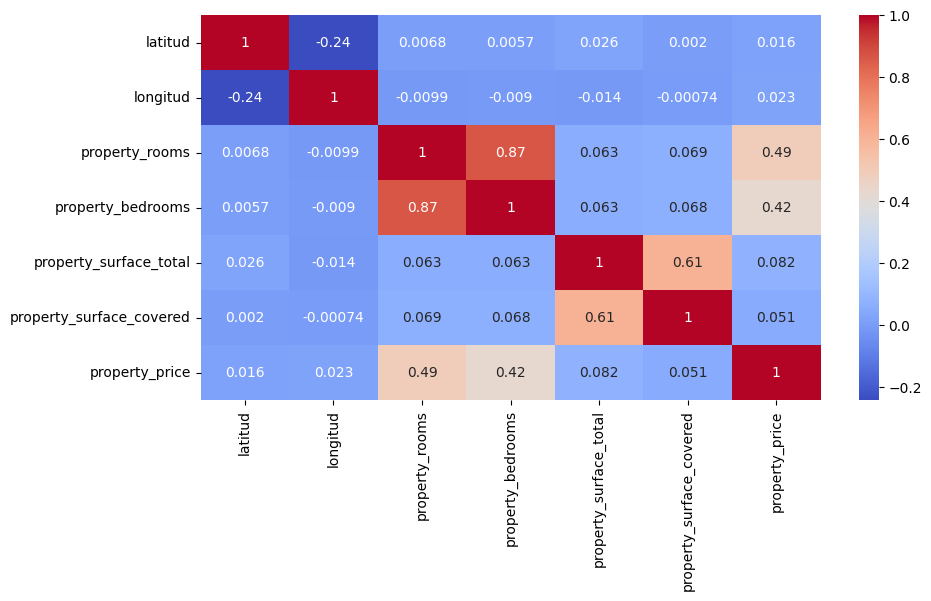

In [168]:
matriz_correlacion=viviendas_caba_train.corr()

plt.figure(figsize=(10,5))
sns.heatmap(matriz_correlacion, annot = True,cmap = 'coolwarm')
plt.show()

Observando el grafico de correlaciones, podemos ver dos relaciones obvias, que son la cantidad de cuartos con cantidad de habitaciones y la superficie total con la superficie cubierta.  
Ademas podemos notar una leve correlacion entre el precio y la cantidad de habitaciones, lo cual se condice con la realidad.

##### Conclusiones generales del Análisis Exploratorio

Vendemos mayormente departamentos, hay datos erroneos que estan por fuera de la lat y long de caba. 
Se suele vender propiedades con pocas habitaciones y a su vez que hay propiedades con mas dormitorios que habitaciones lo cual carece de sentido. 
Los barrios con mas propiedades en venta son Palermo, Belgrano y Caballito. En Catalinas se vende poco zona de oficina.
Hay propiedades con mucha mas superficie cubierta que total, es decir edificios.
Todos los graficos y conclusiones vistas hasta ahora, se ven afectadas por datos faltantes, redudantes y outliers.

### Duplicados

Nos aseguramos de no tener datos duplicados en el dataset.

In [169]:
duplicados = viviendas_caba_train[viviendas_caba_train.duplicated()]
duplicados.head(3)

start_date   end_date    latitud   longitud    barrio vecindad  \
6873   2021-02-09 2021-02-11 -34.633226 -58.376409  Barracas      NaN   
46265  2021-04-21 2021-06-05 -34.544750 -58.461909     Nuñez      NaN   
209331 2021-11-29 2022-01-27 -34.600297 -58.462799  Paternal      NaN   

       property_type  property_rooms  property_bedrooms  \
6873            Casa             NaN                7.0   
46265   Departamento             NaN                NaN   
209331  Departamento             2.0                1.0   

        property_surface_total  property_surface_covered  property_price  \
6873                       NaN                     265.0        350000.0   
46265                     60.0                      55.0        170000.0   
209331                    45.0                      40.0         60000.0   

                                           property_title  
6873    CASA  SOBRE TERRENO PROPIO  A METROS DE  AVENIDA   
46265                                Departamento - Nuñez  
209331                CUCHA CUCHA 2400 2 AMB POR ESCALERA

Vemos que tenemos 1222 filas duplicadas pero tambien observamos que es posible tener departamentos duplicados ya que en un mismo edificio puede haber haber 2 departamentos casi idénticos en cuanto a sus características.
Por lo que decidimos solo eliminar las casas y PHs duplicados (ya que es muy poco probable tener 2 o mas con las mismas características, precio y barrio).

In [170]:
cant_filas_antes_de_borrar = viviendas_caba_train.shape[0]
viviendas_caba_train.drop((duplicados[duplicados.property_type != 'Departamento']).index, axis=0, inplace=True)
print(f'cantidad de filas borradas: {cant_filas_antes_de_borrar- viviendas_caba_train.shape[0]}')

cantidad de filas borradas: 73


Vemos que eliminamos 103 viviendas duplicadas.

### Datos Faltantes :

##### Datos faltantes a nivel columna:

Al principio de la notebook ya eliminamos dos columnas, l_5 y l_6, ya que no contaban con ningun dato. Ahora examinaremos el resto de las columnas.

<AxesSubplot: title={'center': 'Porcentaje de datos faltantes por categoria'}, xlabel='Categoria', ylabel='Porcentaje'>

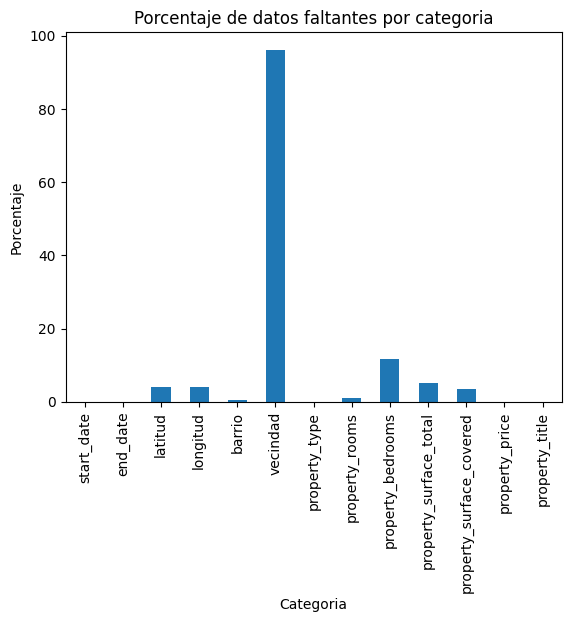

In [171]:
((viviendas_caba_train.isna().sum())/viviendas_caba_train.shape[0]*100).plot.bar(xlabel = 'Categoria', ylabel = 'Porcentaje', title = 'Porcentaje de datos faltantes por categoria')

##### Datos faltantes a nivel fila:

<AxesSubplot: title={'center': 'Porcentaje de datos faltantes por fila'}, xlabel='Cantidad de datos faltantes', ylabel='Porcentaje'>

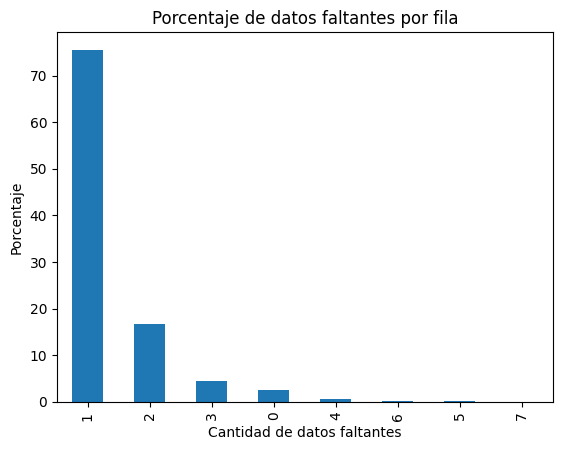

In [172]:
((viviendas_caba_train.isnull().sum(axis=1).value_counts())/viviendas_caba_train.shape[0]*100).plot.bar(xlabel = 'Cantidad de datos faltantes', ylabel = 'Porcentaje', title = 'Porcentaje de datos faltantes por fila')

Vemos que tenemos un gran porcentaje de filas que tienen un solo dato faltante.

#### Conclusiones de sobre faltantes

Hay una alta cantidad de propiedades que tienen al menos un dato faltante, por lo que es necesario hacer una reparación del dataset.  
Tenemos distintas formas de abordar los datos faltantes, algunas son las siguientes:
+ Eliminar las filas con datos faltantes.
    - Esta opcion es un poco "violenta" ya que hay formas de reconstruir los datos.
+ Imputar datos en base a la media, moda, o mediana.
    - Puede quedar distorsionado según la varianza de los datos.
+ Imputar en base a relacion con otra/s variables, existen distintas formas de hacer esto:
    - Regresion lineal (para variables cuantitativas)
    - Regresion logistica (para variables cualitativas)
    - Cold-deck
    - Hot-deck
    - Mice

### Valores atípicos 

##### Análisis de valores atípicos univariado

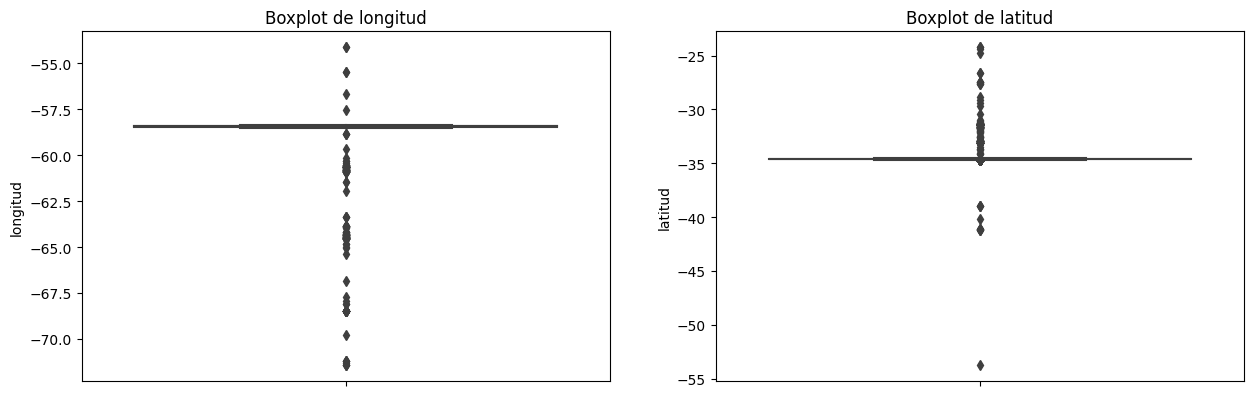

In [173]:
plt.figure(figsize=(15,10))
plt.subplot(221)
sns.boxplot(y="longitud", data=viviendas_caba_train).set(title = 'Boxplot de longitud' )
plt.subplot(222)
sns.boxplot(y="latitud", data=viviendas_caba_train).set(title = 'Boxplot de latitud' )
plt.show()

En el caso de latitud y longitud, vemos que tenemos una gran dispersión, lo cual no debería ocurrir ya que todas las viviendas deberían pértenecer a CABA.

 ------

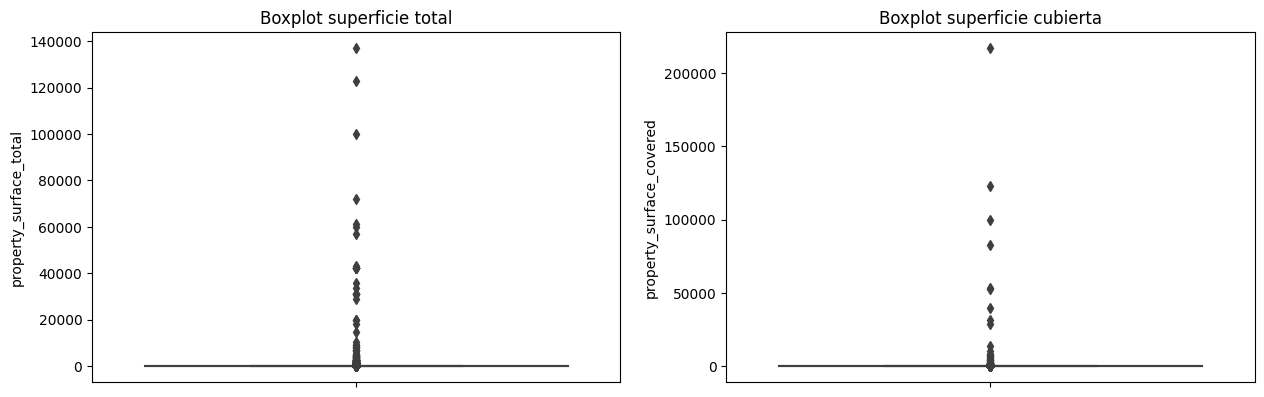

In [174]:
plt.figure(figsize=(15,10))
plt.subplot(221)
sns.boxplot(y="property_surface_total", data=viviendas_caba_train).set(title = 'Boxplot superficie total' )
plt.subplot(222)
sns.boxplot(y="property_surface_covered", data=viviendas_caba_train).set(title = 'Boxplot superficie cubierta' )
plt.show()

En ambos graficos notamos una dispersión muy grande, por lo que decidimos ver valores según el tipo de propiedad.

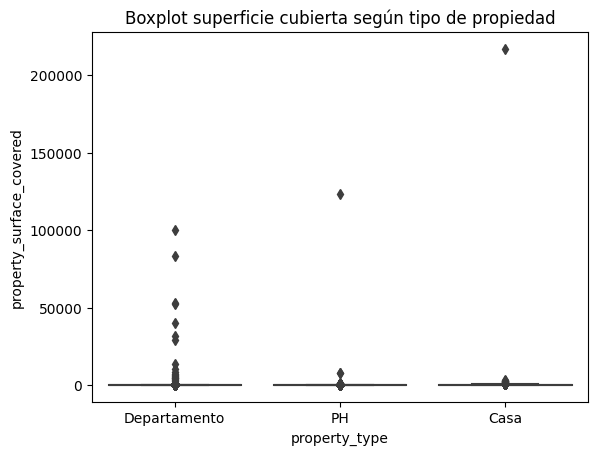

In [175]:
sns.boxplot(x=viviendas_caba_train.property_type, y=viviendas_caba_train.property_surface_covered).set(title = 'Boxplot superficie cubierta según tipo de propiedad' )
plt.show()

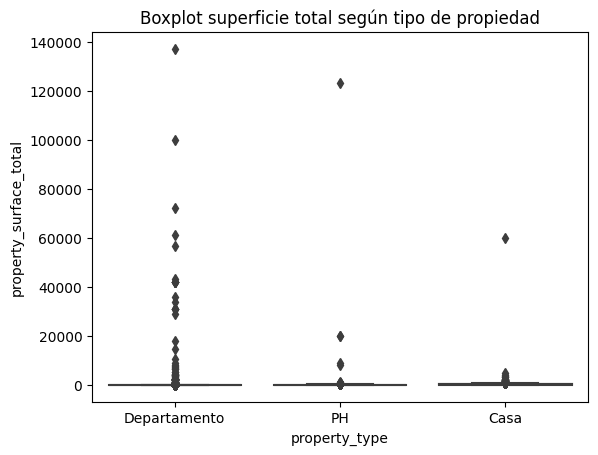

In [176]:
sns.boxplot(x=viviendas_caba_train.property_type, y=viviendas_caba_train.property_surface_total).set(title = 'Boxplot superficie total según tipo de propiedad' )
plt.show()


Vemos que la gran dispersión se da en todos los tipos de viviendas, por lo que probablemente tengamos valores atípicos que imposibilitan la comprensión de los gráficos.

----

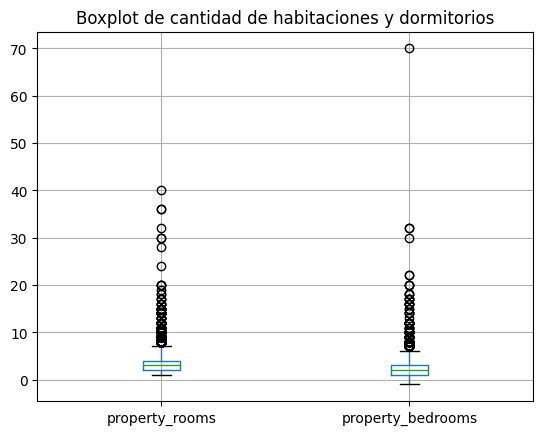

In [177]:
boxplot_rooms = viviendas_caba_train.boxplot(column = ['property_rooms','property_bedrooms']).set(title= 'Boxplot de cantidad de habitaciones y dormitorios')

Notamos que hay propiedades con cantidad de ambientes excesivamente grande y además tenemos viviendas con más dormitorios que ambientes lo que carece de lógica.

 -----

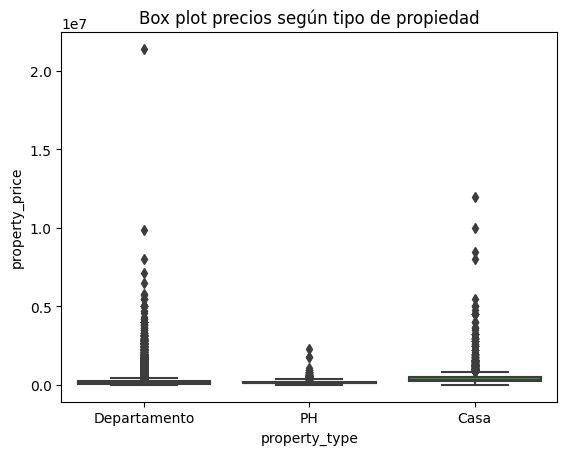

In [178]:
sns.boxplot(x=viviendas_caba_train.property_type, y=viviendas_caba_train.property_price).set(title = 'Box plot precios según tipo de propiedad')
plt.show()

En cuanto a precio vemos otra vez una gran dispersión acompañada de precios irrisorios como 21M de dólares.


##### Análisis de valores atípicos multivariado

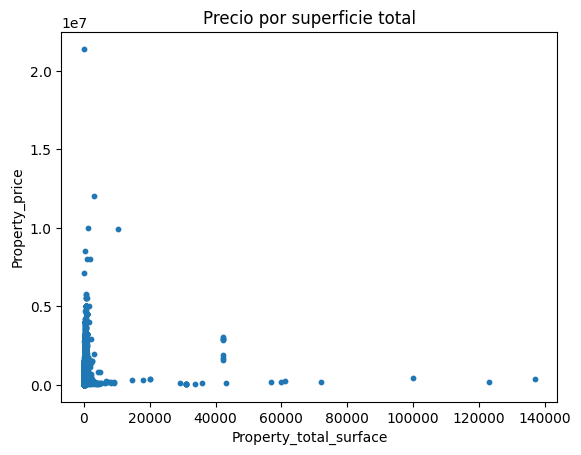

In [179]:
grf_price_surface=viviendas_caba_train.plot.scatter(x="property_surface_total", y="property_price", s=10).set(title="Precio por superficie total",xlabel='Property_total_surface',ylabel='Property_price') 

De este grafico vemos:
+ Los valóres atípicos dificultan la comprensión del gráfico.
+ No se ve una correlacion a simple vista de precio-superficie total. Suponemos que se debe a que influye mas la zona que la superficie total en el precio de las propiedades.
+ Hay varios outliers previamente no detectados: 
    + Propiedades con precios extremadamente bajos y superficies enormes.
    + Propiedades con precios muy altos y superficies pequeñas.

Tambien sabemos que la mayor cantidad de propiedades se encuentran en la zona inferior izquierda del grafico. Una representacion mas precisa de esa zona podria evidenciar una relacion mas clara de los atributos. 

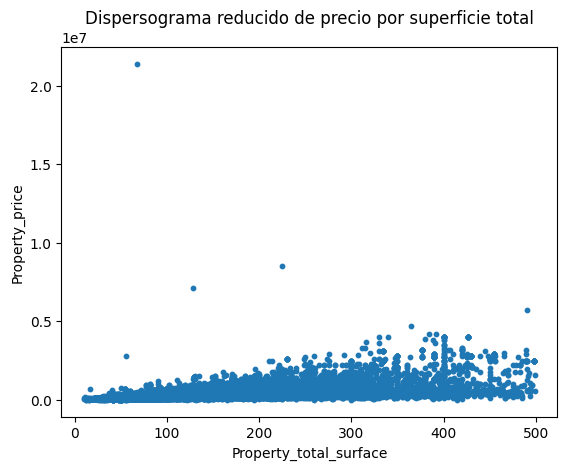

In [180]:
aux = viviendas_caba_train[viviendas_caba_train.property_surface_total < 500]
grf_sup=aux.plot.scatter(x="property_surface_total", y="property_price", s=10).set(title="Dispersograma reducido de precio por superficie total",xlabel='Property_total_surface',ylabel='Property_price') 

Ahora si podemos ver una relación entre el precio y la superficie total, aunque los valores atípicos nos dificultan la tarea.

----

[Text(0.5, 1.0, 'Dispersograma de cantidad de ambientes vs cantidad de dormitorios'),
 Text(0.5, 0, 'Property_bedrooms'),
 Text(0, 0.5, 'Property_rooms')]

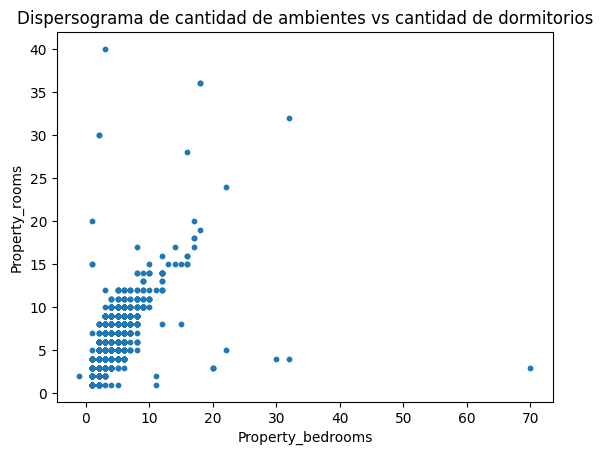

In [181]:
viviendas_caba_train.plot.scatter(x="property_bedrooms", y="property_rooms", s=10).set(title="Dispersograma de cantidad de ambientes vs cantidad de dormitorios",xlabel='Property_bedrooms',ylabel='Property_rooms') 

A simple vista vemos una relacion bastante lineal entre cantidad de ambientes y cantidad de dormitorios.

##### Conclusión sobre valores atípicos 

Hay varios outliers en todas las variables.
+ Hay valores de superficie demasiado grandes como para pertenecer a un PH, casa, o departamento.
+ Los outliers en cantidades de ambientes podrian pertenecer a casas muy grandes, pero deberian ser muy pocas por ser de CABA.
+ La variedad de precios es demasiado grande, inferimos que hubieron casos de errores en la carga de los datos. 
+ Tenemos viviendas con demasiados ambientes y dormitorios e incluso algunas con mas dormitorios que ambientes.

### Reparación de datos:

#### Quitamos columnas no utiles:

Lo primero que vemos que mas llama la atención es la vecindad que tiene mas del 96% de datos faltantes. Como habiamos visto mas arriba los unicos datos que tiene esta columna provienen de Palermo. Para tratar estos datos faltantes notamos 4 opciones. Eliminar la columna completamente, imputar los datos correspondientes a Palermo o eliminar la columna pero en vez de tener en la columna barrio a Palermo, tener las 4 vecinadades. O si no tener 5 barrios que representen a Palermo, uno generico y las 4 vecindades. Decidimos eliminar de lleno a la columna ya que era muy grande el porcentaje de datos faltantes.

In [182]:
def transformacion_drop_vecindad(df_vivienda):
    df_vivienda.drop(columns=['vecindad'], inplace=True)
transformacion_drop_vecindad(viviendas_caba_train)

Luego de eliminar la vecindad volvemos  agraficar para ver el estado actual de los datos faltantes.

<AxesSubplot: title={'center': 'Porcentaje de datos faltantes por fila'}, xlabel='Cantidad de datos faltantes', ylabel='Porcentaje'>

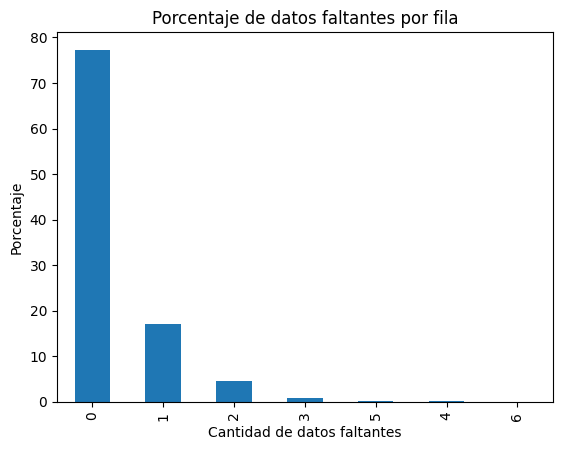

In [183]:
((viviendas_caba_train.isnull().sum(axis=1).value_counts())/viviendas_caba_train.shape[0]*100).plot.bar(xlabel = 'Cantidad de datos faltantes', ylabel = 'Porcentaje', title = 'Porcentaje de datos faltantes por fila')

Vemos que casi un 80% de nuestras filas no tienen datos faltantes.

<AxesSubplot: title={'center': 'Porcentaje de datos faltantes por categoria'}, xlabel='Categoria', ylabel='Porcentage'>

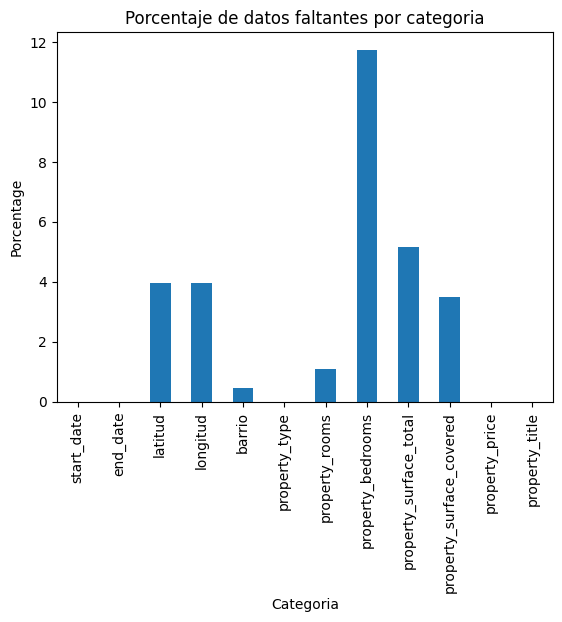

In [184]:
((viviendas_caba_train.isna().sum())/viviendas_caba_train.shape[0]*100).plot.bar(xlabel = 'Categoria', ylabel = 'Porcentage', title = 'Porcentaje de datos faltantes por categoria')

#### Limpieza de viviendas fuera de CABA por coordenadas

Creamos un geodataframe con los filas del original que si tienen latitud y longitud.

In [185]:
def obtener_lat_long(df_vivienda):
    shapely.speedups.enable()
    con_lat_y_lon = df_vivienda.copy().loc[(df_vivienda["latitud"].notna()) & (df_vivienda["longitud"].notna())] 
    con_lat_y_lon = gp.GeoDataFrame(con_lat_y_lon, geometry=gp.points_from_xy(con_lat_y_lon.longitud, con_lat_y_lon.latitud))
    return con_lat_y_lon

In [186]:
con_lat_y_lon = obtener_lat_long(viviendas_caba_train)

Unimos todos los barrios de CABA para formar una GeoSerie con el poligono de CABA.

C:\Users\forte\AppData\Local\Temp\ipykernel_4064\2670886068.py:2: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  caba_poly = gp.GeoSeries(cascaded_union(polygons))


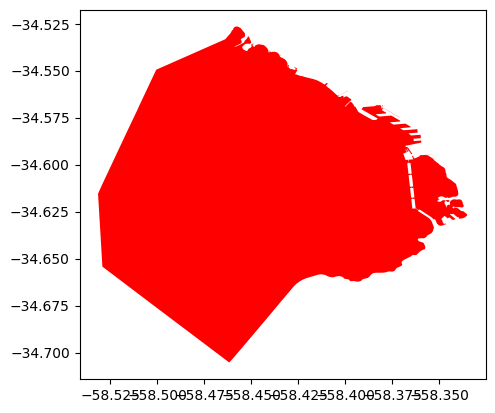

In [187]:
polygons = poly.geometry.to_list()
caba_poly = gp.GeoSeries(cascaded_union(polygons))
caba_poly.plot(color = 'red')
plt.show()


Creamos una mascara para distinguir las viviendas que estan fuera y dentro del poligono de CABA (como crear la mascara es un proceso muy demandante la guardamos en un archivo CSV)

In [188]:
#creo un vector true/false si la vivienda está en el barrio (interseccion punto con poligono)
def crear_mascara(df_vivienda, nombre_destino):
    con_lat_y_lon = obtener_lat_long(df_vivienda)
    mask = con_lat_y_lon.within(caba_poly.iloc[0]) 
    mask.to_csv(nombre_destino, index = True, header=None)
    return mask
#crear_mascara(viviendas_caba_train, './Datasets/en_caba_train_mask.csv')

Leemos la mascara y generamos un dataset para viviendas dentro de caba y otro para las de fuera.

In [189]:
def separar_segun_esten_dentro_de_caba(df_vivienda, nombre_destino, con_lat_y_lon):
    mask = pd.read_csv(nombre_destino, header=None, names=['index', 'bool']).copy()
    mask.set_index('index',inplace=True)

    viviendas_dentro_caba = con_lat_y_lon.loc[mask['bool']]
    viviendas_fuera_de_caba = con_lat_y_lon.loc[~mask['bool']]
    return viviendas_dentro_caba, viviendas_fuera_de_caba
    
viviendas_dentro_caba, viviendas_fuera_de_caba = separar_segun_esten_dentro_de_caba(viviendas_caba_train, './Datasets/en_caba_train_mask.csv', con_lat_y_lon)

In [190]:
print(f'Número de filas de viviendas con latitud y longitud: {con_lat_y_lon.shape[0]}')
print(f'Número de filas de viviendas con latitud y longitud en CABA: {viviendas_dentro_caba.shape[0]}')
print(f'Número de filas de viviendas con latitud y longitud fuera de CABA: {viviendas_fuera_de_caba.shape[0]}')

Número de filas de viviendas con latitud y longitud: 72344
Número de filas de viviendas con latitud y longitud en CABA: 72173
Número de filas de viviendas con latitud y longitud fuera de CABA: 171


Hacemos un analisis visual de las viviendas fuera de CABA para ver si es correcto eliminarlas.

In [191]:
viviendas_fuera_de_caba.tail(5)

start_date   end_date    latitud   longitud barrio property_type  \
10486  2021-01-13 2200-12-31 -41.163826 -71.438923    NaN          Casa   
131209 2021-05-27 2021-06-05 -31.448986 -60.930366    NaN  Departamento   
45536  2021-05-02 2021-06-05 -32.065926 -64.527838    NaN          Casa   
54727  2021-01-11 2021-02-09 -31.664340 -63.885916    NaN          Casa   
229657 2021-07-27 2022-06-04 -38.958207 -67.923565    NaN          Casa   

        property_rooms  property_bedrooms  property_surface_total  \
10486              NaN                3.0                     NaN   
131209             4.0                2.0                   150.0   
45536              3.0                2.0                   307.0   
54727              5.0                4.0                     NaN   
229657             NaN                3.0                   330.0   

        property_surface_covered  property_price  \
10486                      100.0        410000.0   
131209                     150.0        200000.0   
45536                      106.0        139000.0   
54727                      145.0        190000.0   
229657                     150.0         95000.0   

                                           property_title  \
10486   BAJO EL PRECIO!! CASA 4 AMB. EN LA LOMA - CERR...   
131209  SE VENDE SEMIPISO DE CATEGORÍA EN EL CENTRO DE...   
45536   Se Vende Casa Amoblada en Santa Rosa de Calamu...   
54727        VENTA CASA CON PILETA Y COCHERA - B° PRIVADO   
229657  VENDE CASA 3 dormitorios en Barrio Los Frutale...   

                           geometry  
10486   POINT (-71.43892 -41.16383)  
131209  POINT (-60.93037 -31.44899)  
45536   POINT (-64.52784 -32.06593)  
54727   POINT (-63.88592 -31.66434)  
229657  POINT (-67.92357 -38.95821)

Concluimos en que está bien eliminarlas del dataset de entrenamiento.

In [192]:

cant_filas_antes_de_borrar = viviendas_caba_train.shape[0]
viviendas_caba_train.drop(viviendas_fuera_de_caba.index, axis=0, inplace=True)

print(f'cantidad de filas borradas: {cant_filas_antes_de_borrar- viviendas_caba_train.shape[0]}')

cantidad de filas borradas: 171


Para analizar el cambio graficamente graficamos primero el mapa con todas las viviendas y luego el mapa con unicamente las viviendas de CABA.

[Text(0.5, 1.0, 'latitud y longitud antes de eliminar valores atípicos')]

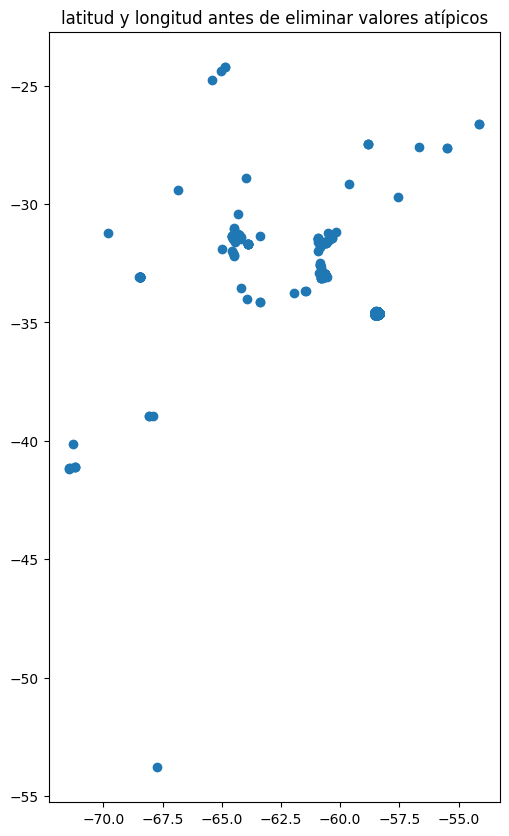

In [193]:
fig, ax = plt.subplots(figsize=(10,10))
poly.plot(ax=ax,column='BARRIO',alpha=0.5)
con_lat_y_lon.plot(ax=ax).set(title = 'latitud y longitud antes de eliminar valores atípicos' )

[Text(0.5, 1.0, 'latitud y longitud después de eliminar valores atípicos')]

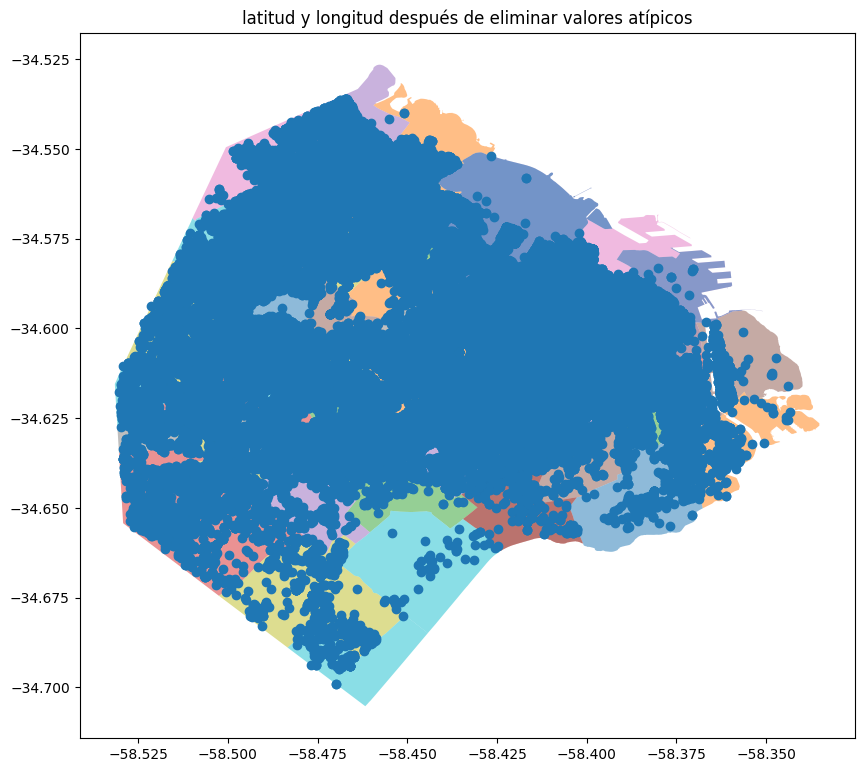

In [194]:
fig, ax = plt.subplots(figsize=(10,10))
poly.plot(ax=ax,column='BARRIO',alpha=0.5)
viviendas_dentro_caba.plot(ax=ax).set(title = 'latitud y longitud después de eliminar valores atípicos' )

Visualmente vemos la corrección drástica que se logró en el gráfico de latitud vs longitud.

#### Reparacíon de barrios faltantes por coordenadas

Primero veamos cuantas viviendas no tienen ni barrio, ni longitud, ni latitud.

In [195]:
sin_ubicacion = viviendas_caba_train[(viviendas_caba_train.barrio.isna()) & (viviendas_caba_train.latitud.isna()) & ((viviendas_caba_train.longitud.isna()))]
sin_ubicacion.shape[0]

139

Como no es una cantidad importante decidimos dropearlas.

In [196]:
cant_filas_antes_de_borrar = viviendas_caba_train.shape[0]
viviendas_caba_train.drop(sin_ubicacion.index, axis=0, inplace=True)
print(f'cantidad de filas borradas: {cant_filas_antes_de_borrar- viviendas_caba_train.shape[0]}')

cantidad de filas borradas: 139


Vemos que hay propiedades que no tienen barrio, pero si tienen latitud y longitud por lo cual podríamos completar su barrio en base a sus coordenadas:

In [197]:
viviendas_caba_train[viviendas_caba_train.barrio.isna()].longitud.notna().sum()

40

Creamos un nuevo GeoDataSet con todas las viviendas que tienen coordenadas pero no barrio.

In [198]:
def obtener_sin_barrio_con_coord(df_viviendas):
    sin_barrio_con_coord = df_viviendas.copy().loc[(df_viviendas["barrio"].isna()) & (df_viviendas["latitud"].notna()) & (df_viviendas["longitud"].notna())] 
    sin_barrio_con_coord = gp.GeoDataFrame(sin_barrio_con_coord, geometry=gp.points_from_xy(sin_barrio_con_coord.longitud, sin_barrio_con_coord.latitud))
    return sin_barrio_con_coord

In [199]:
def imputar_barrios(sin_barrio_con_coord):
    con_barrio_por_coordenadas = sin_barrio_con_coord.copy()
    for barrio in poly.BARRIO:
        indice_barrio = poly[poly['BARRIO'] == barrio].index[0] 
        mask = sin_barrio_con_coord.within(poly.loc[indice_barrio, 'geometry']) 
        con_barrio_por_coordenadas.loc[mask,"barrio"] = barrio.title()
    return con_barrio_por_coordenadas

In [200]:
def transformacion_imputar_barrios(df_viviendas):
   sin_barrio_con_coord = obtener_sin_barrio_con_coord(df_viviendas)
   return imputar_barrios(sin_barrio_con_coord) , sin_barrio_con_coord
con_barrio_por_coordenadas, sin_barrio_con_coord = transformacion_imputar_barrios(viviendas_caba_train)

Graficamos las viviendas a las que se les agregó un barrio sobre el mapa de CABA.

[Text(0.5, 1.0, 'barrios completados segun coordenadas')]

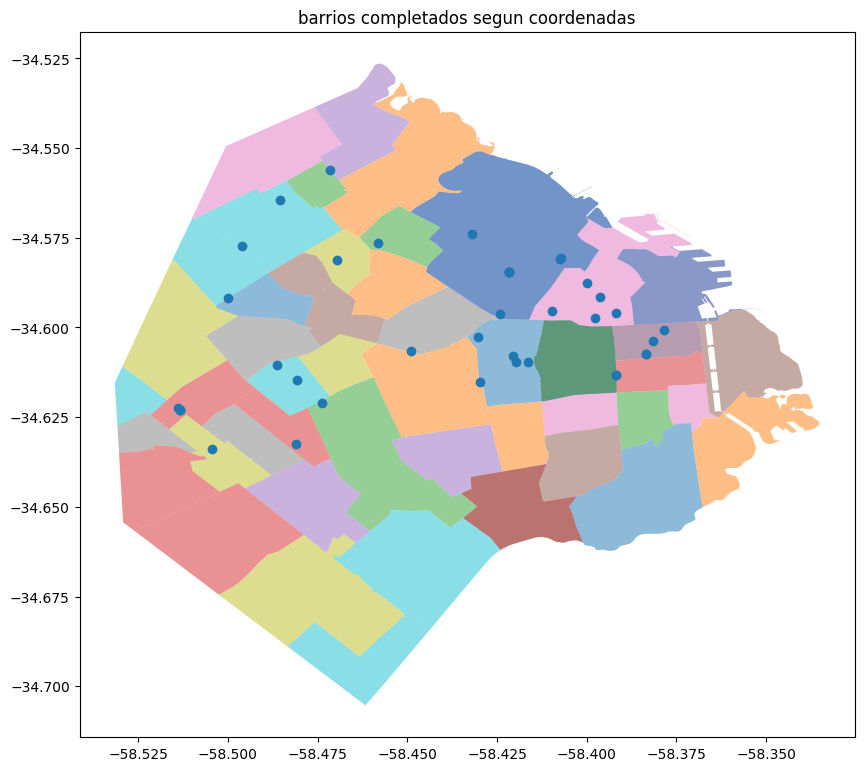

In [201]:
mapa_barrios_completados = gp.GeoDataFrame(con_barrio_por_coordenadas, geometry=gp.points_from_xy(con_barrio_por_coordenadas.longitud, con_barrio_por_coordenadas.latitud))
fig, ax = plt.subplots(figsize=(10,10))
poly.plot(ax=ax,column='BARRIO',alpha=0.5)
mapa_barrios_completados.plot(ax=ax).set(title = 'barrios completados segun coordenadas' )

In [202]:
print(f'Cantidad de viviendas sin barrio y con coordenadas: {sin_barrio_con_coord.barrio.isna().sum()}')
print(f'Cantidad de barrios que no se pudieron completar: {con_barrio_por_coordenadas.barrio.isna().sum()}')

Cantidad de viviendas sin barrio y con coordenadas: 40
Cantidad de barrios que no se pudieron completar: 0


Vemos cuantos datos aun no tienen barrio asignado.

In [203]:
print(f'Cantidad de viviendas sin barrio: {viviendas_caba_train.barrio.isna().sum()}')

Cantidad de viviendas sin barrio: 40


Como son muy pocos datos ,dropeamos el resto que aun no tenian barrio asignado.

In [204]:
def transformacion_drop_barrios(df_viviendas, con_barrio_por_coordenadas):
    con_barrio_por_coordenadas.drop("geometry", axis = 1, inplace = True)
    df_viviendas.loc[con_barrio_por_coordenadas.index] = con_barrio_por_coordenadas 
transformacion_drop_barrios(viviendas_caba_train, con_barrio_por_coordenadas)

In [205]:
print(f'Cantidad de viviendas sin barrio: {viviendas_caba_train.barrio.isna().sum()}')

Cantidad de viviendas sin barrio: 0


Vemos que ya no nos quedan mas propiedades sin barrios faltantes.

#### Reparación de cantidad de dormitorios en base a cantidad de habitaciones y viceversa

##### Tratamos outliers habitacionales

Anteriormente vimos que la relacion entre cantidad de dormitorios y habitaciones era bastante lineal. Por lo que podemos completar datos faltantes utilizando una regresión lineal. Como la regresion lineal es muy sensibe a los valores atipicos primero debemos tratarlos.
Comenzamos buscando estos valores atípicos:

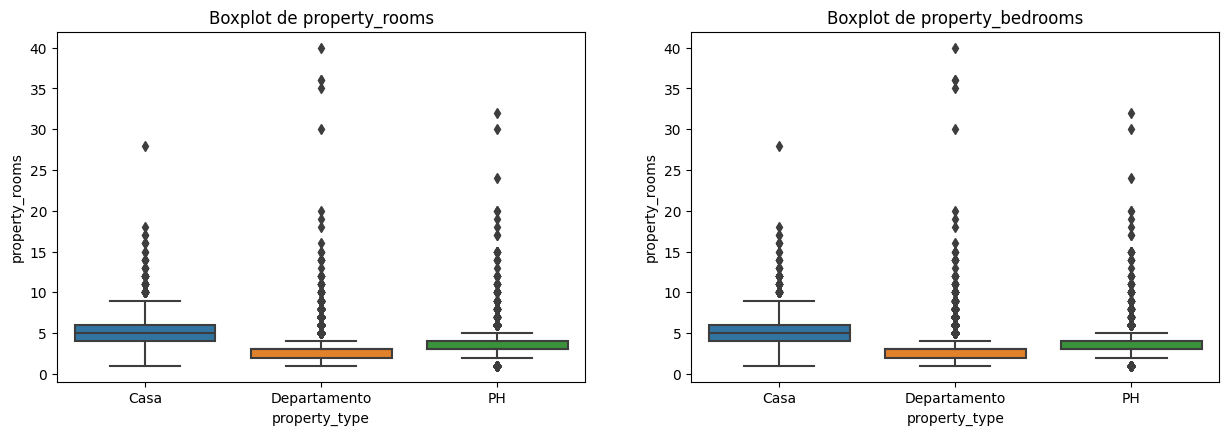

In [206]:
plt.figure(figsize=(15,10))
plt.subplot(221)
sns.boxplot(x=viviendas_caba_train_copy.property_type, y=viviendas_caba_train_copy.property_rooms).set(title = 'Boxplot de property_rooms' )
plt.subplot(222)
sns.boxplot(x=viviendas_caba_train_copy.property_type, y=viviendas_caba_train_copy.property_rooms).set(title = 'Boxplot de property_bedrooms' )
plt.show()

Pensamos en sacar a todas las viviendas que esten por fuera de 1.5*IQR.

In [207]:
#Calculo los cuantiles de las variables rooms_dep,rooms_ph,rooms_casa
viviendas_con_rooms = viviendas_caba_train[viviendas_caba_train.property_rooms.notna()]


rooms_dep_q3, rooms_dep_q1 = np.percentile(viviendas_con_rooms[viviendas_con_rooms.property_type == 'Departamento'].property_rooms, [75 ,25])
rooms_ph_q3, rooms_ph_q1 = np.percentile(viviendas_con_rooms[viviendas_con_rooms.property_type == 'PH'].property_rooms, [75 ,25])
rooms_casa_q3, rooms_casa_q1 = np.percentile(viviendas_con_rooms[viviendas_con_rooms.property_type == 'Casa'].property_rooms, [75 ,25])

#Calculo e rango intercuartil de las variables x,y,z
iqr_dep = rooms_dep_q3 - rooms_dep_q1
iqr_ph = rooms_ph_q3 - rooms_ph_q1
iqr_casa = rooms_casa_q3 - rooms_casa_q1

print(iqr_dep,iqr_ph,iqr_casa)

1.0 1.0 2.0


In [208]:
deptos_que_quedan= viviendas_con_rooms[viviendas_con_rooms.property_type == 'Departamento'].query(' property_rooms >= (@rooms_dep_q1 - @iqr_dep*1.5) & property_rooms <= (@rooms_dep_q3 + @iqr_dep*1.5) ')
print(deptos_que_quedan.shape)
print(viviendas_con_rooms[viviendas_con_rooms.property_type == 'Departamento'].shape)

(60113, 12)
(64041, 12)


Nos dimos cuenta que este no es un buen criterio a tomar, porque estariamos eliminando demasiadas viviendas que aunque tengas más habitaciones de lo normal y sean outliers, no parecen algo fuera de lo posible o razonable. Es por esto que decidimos utilizar criterios simples usando el sentido común, como que consideramos atípicos a departamentos con mas de 10 habitacions, casas con mas de 20, y ph 15. 
Primero pensamos en tratar a algunos de esos outliers manualmente, corrigiendo algunos errores de carga, sin embargo optamos por eliminarlos.

In [209]:
def transformacion_drop_property_rooms(df_viviendas):
    deptos_a_borrar = df_viviendas[(df_viviendas.property_type == 'Departamento') & (df_viviendas.property_rooms >10)]
    ph_a_borrar = df_viviendas[(df_viviendas.property_type == 'PH') & (df_viviendas.property_rooms >15)]
    casas_a_borrar =  df_viviendas[(df_viviendas.property_type == 'Casa') & (df_viviendas.property_rooms >20)]

    viviendas_a_borrar = pd.concat([deptos_a_borrar, ph_a_borrar, casas_a_borrar])
    df_viviendas.drop(viviendas_a_borrar.index, axis=0,inplace=True)
transformacion_drop_property_rooms(viviendas_caba_train)

Para verificar la distribución tras eliminar los outliers, comparamos los boxplot y densityplot de antes y despues de eliminarlos

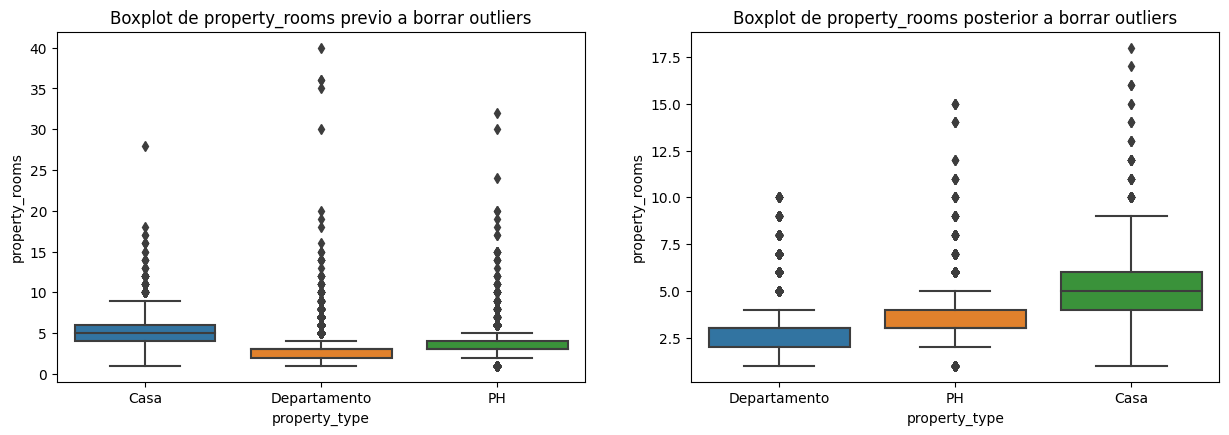

In [210]:
plt.figure(figsize=(15,10))
plt.subplot(221)
sns.boxplot(x=viviendas_caba_train_copy.property_type, y=viviendas_caba_train_copy.property_rooms).set(title = 'Boxplot de property_rooms previo a borrar outliers' )
plt.subplot(222)
sns.boxplot(x=viviendas_caba_train.property_type, y=viviendas_caba_train.property_rooms).set(title = 'Boxplot de property_rooms posterior a borrar outliers' )
plt.show()

Podemos ver como ahora los cuartiles estan mejor representados sin la presencia de los outliers groseros.

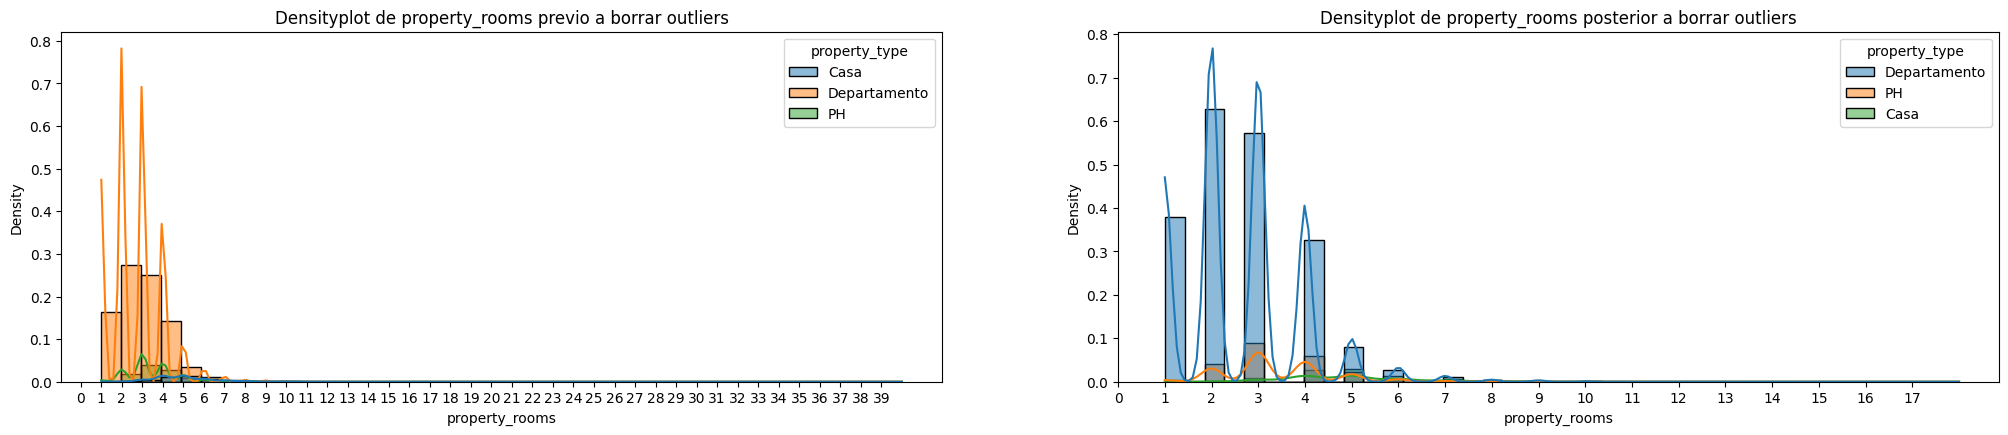

In [211]:
plt.figure(figsize=(25,10))
plt.subplot(221)
sns.histplot(data=viviendas_caba_train_copy,x='property_rooms' , color='navy', kde=True, alpha = 0.5, bins=40,hue="property_type", stat="density").set(title = 'Densityplot de property_rooms previo a borrar outliers' )
plt.xticks(range(40))
plt.subplot(222)
sns.histplot(data=viviendas_caba_train,x='property_rooms' , color='navy', kde=True, alpha = 0.5, bins=40,hue="property_type", stat="density").set(title = 'Densityplot de property_rooms posterior a borrar outliers' )
plt.xticks(range(18))
plt.show()

##### Tratamos outliers bedrooms:

Repetimos el procesos anmterior para los bedrooms.

Decimos que considerariamos outliers a aquellos departamentos que tengan 9 bedrooms, PHs con 13, casas con 18. Esto es debido a que viviendas tan grandes deben tener algun cuarto, ya sea el baño o la cocina que no son bedrooms.

In [212]:
def transformacion_drop_property_bedrooms(df_viviendas):
    deptos_a_borrar = df_viviendas[(df_viviendas.property_type == 'Departamento') & (df_viviendas.property_bedrooms >9)]
    ph_a_borrar = df_viviendas[(df_viviendas.property_type == 'PH') & (df_viviendas.property_bedrooms >13)]
    casas_a_borrar =  df_viviendas[(df_viviendas.property_type == 'Casa') & (df_viviendas.property_bedrooms >18)]

    viviendas_a_borrar = pd.concat([deptos_a_borrar, ph_a_borrar, casas_a_borrar])
    df_viviendas.drop(viviendas_a_borrar.index, axis=0,inplace=True)
transformacion_drop_property_bedrooms(viviendas_caba_train)

Para verificar la distribución tras eliminar los outliers, comparamos los boxplot y densityplot de antes y despues de eliminarlos.

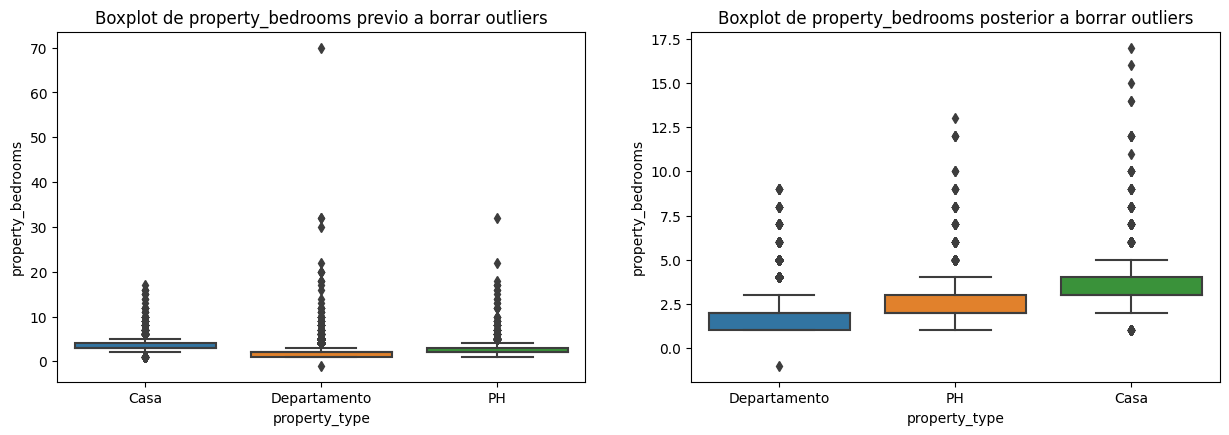

In [213]:
plt.figure(figsize=(15,10))
plt.subplot(221)
sns.boxplot(x=viviendas_caba_train_copy.property_type, y=viviendas_caba_train_copy.property_bedrooms).set(title = 'Boxplot de property_bedrooms previo a borrar outliers' )
plt.subplot(222)
sns.boxplot(x=viviendas_caba_train.property_type, y=viviendas_caba_train.property_bedrooms).set(title = 'Boxplot de property_bedrooms posterior a borrar outliers' )
plt.show()

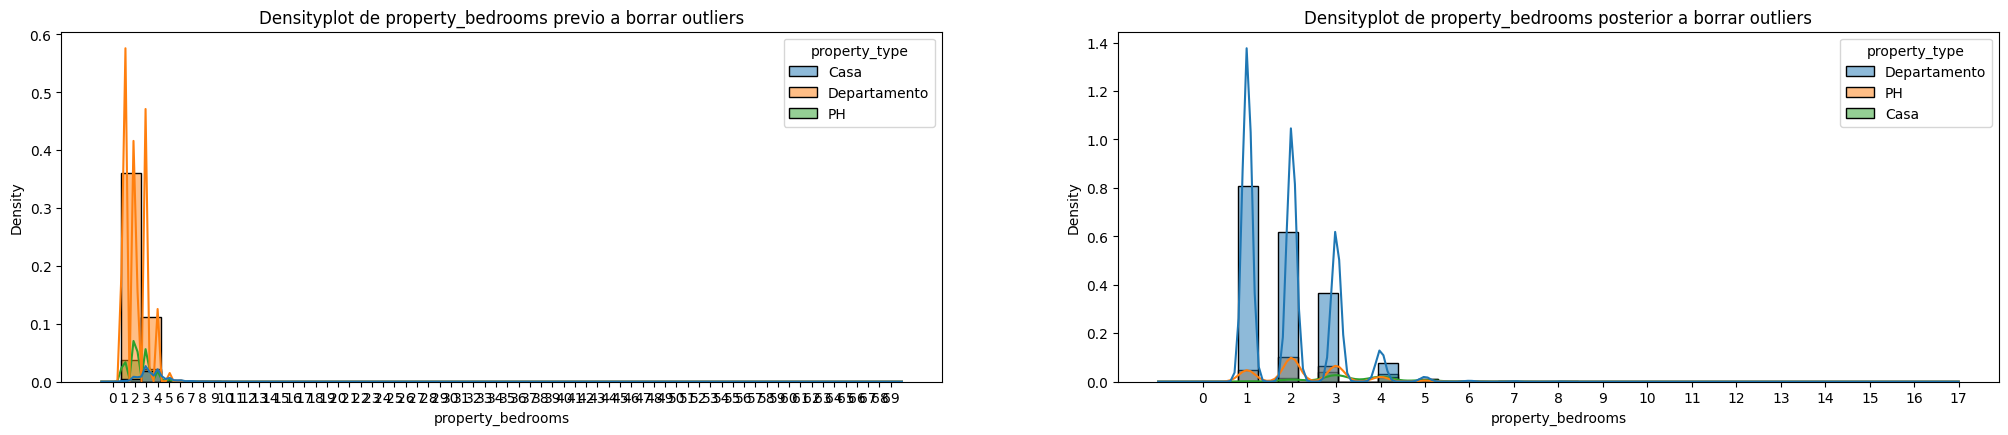

In [214]:
plt.figure(figsize=(25,10))
plt.subplot(221)
sns.histplot(data=viviendas_caba_train_copy,x='property_bedrooms' , color='navy', kde=True, alpha = 0.5, bins=40,hue="property_type", stat="density").set(title = 'Densityplot de property_bedrooms previo a borrar outliers' )
plt.xticks(range(70))
plt.subplot(222)
sns.histplot(data=viviendas_caba_train,x='property_bedrooms' , color='navy', kde=True, alpha = 0.5, bins=40,hue="property_type", stat="density").set(title = 'Densityplot de property_bedrooms posterior a borrar outliers' )
plt.xticks(range(18))
plt.show()

##### Realizamos regresión lineal entre ambientes y habitaciones

Como habíamos visto en el análisis exploratorio la relación entre ambientes y dormitorios es bastante lineal, por lo que podemos usar una regresión lineal para reparar valores faltantes.

Una vez limpios los valores atípicos, podemos inputar datos sobre cantidad de dormitorios en base a la cantidad de habitaciones utilizando regresión lineal.

In [215]:
#Creo un regresor lineal
modelo_regresion_lineal_simple = LinearRegression()

#Doy el formato adecuado a las variables dependiente e independiente
aux = viviendas_caba_train[viviendas_caba_train.property_rooms.notna() & viviendas_caba_train.property_bedrooms.notna()].copy()

rooms=aux['property_rooms'].values.reshape(-1, 1)
bedrooms=aux['property_bedrooms'].values.reshape(-1, 1)

#Ajusto el modelo
modelo_regresion_lineal_simple.fit(rooms,bedrooms)

#Coeficientes Estimados
B0_e=round(modelo_regresion_lineal_simple.intercept_[0],2) #coef = pendiente
B1_e=round(modelo_regresion_lineal_simple.coef_[0][0],2) #intercept = ordenada al origen

#Muestro el modelo
print(f" El modelo lineal simple ajustado es : property_bedrooms = {B1_e} * property_rooms  + {B0_e}")

 El modelo lineal simple ajustado es : property_bedrooms = 0.73 * property_rooms  + -0.22


In [216]:
#Vemos que valores estima el modelo para cada observacion
property_bedrooms_predict = B1_e * rooms + B0_e

#Lo agregamos en el dataframe
aux['property_bedrooms_predict'] = property_bedrooms_predict
aux.head(5)

start_date   end_date    latitud   longitud     barrio property_type  \
256070 2021-11-03 2022-02-02 -34.566536 -58.479638    Coghlan  Departamento   
211207 2021-11-16 2021-11-18        NaN        NaN  Caballito  Departamento   
228948 2021-03-08 2021-06-05 -34.577033 -58.423367    Palermo  Departamento   
361800 2021-01-16 2021-10-09 -34.580210 -58.412815    Palermo  Departamento   
153179 2021-12-09 2021-12-16 -34.582107 -58.448826    Palermo  Departamento   

        property_rooms  property_bedrooms  property_surface_total  \
256070             2.0                1.0                    65.0   
211207             2.0                1.0                    41.0   
228948             1.0                1.0                    49.0   
361800             1.0                2.0                     NaN   
153179             1.0                1.0                    36.0   

        property_surface_covered  property_price  \
256070                      53.0        198000.0   
211207                      35.0         93000.0   
228948                      44.0        160000.0   
361800                      78.0        290000.0   
153179                      31.0         83789.0   

                                           property_title  \
256070                                  1 - Holmberg 2700   
211207  Departamento de 2 ambientes con balcón aterraz...   
228948  Departamento - Monoambiente - Palermo Nuevo - ...   
361800                            Departamento en Palermo   
153179               Departamento 1 ambiente - OM Palermo   

        property_bedrooms_predict  
256070                       1.24  
211207                       1.24  
228948                       0.51  
361800                       0.51  
153179                       0.51

Veamos en forma gráfica el ajuste que realiza el modelo propuesto

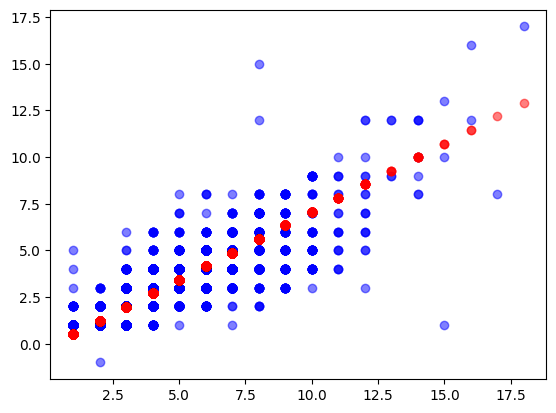

In [217]:
#Grafico las observaciones reales + las estimadas
plt.scatter(aux['property_rooms'],aux['property_bedrooms'],color='blue',alpha=0.5)
plt.scatter(aux['property_rooms'],aux['property_bedrooms_predict'], color='red',alpha=0.5)

In [218]:
corr_pearson = np.corrcoef(aux['property_rooms'], aux['property_bedrooms'])[0][1]
print(f"Correlación Pearson: r={corr_pearson}")

Correlación Pearson: r=0.9219922699333521


Vemos que tenemos un muy buen coeficiente de Correlación Pearson, por lo que estará bien completar este tipo de datos con regresión lineal

Veamos como nos dan las métricas:

In [219]:
import sklearn.metrics as metrics
r2 = metrics.r2_score(bedrooms, property_bedrooms_predict)
print(f"El R2 del modelo es: {r2}")
print("RMSE: " + str(metrics.mean_squared_error(bedrooms, property_bedrooms_predict, squared=False)))

El R2 del modelo es: 0.8498966102263954
RMSE: 0.39882508600498845


##### Imputamos bedrooms a base de rooms

In [220]:
sin_bedroom_con_room = viviendas_caba_train[viviendas_caba_train.property_rooms.notna() & viviendas_caba_train.property_bedrooms.isna()].copy()
sin_bedroom_con_room.head(3)

start_date   end_date    latitud   longitud        barrio  \
27438  2021-12-03 2022-01-27 -34.645625 -58.459408        Flores   
155007 2021-02-03 2022-05-15        NaN        NaN  Villa Crespo   
163967 2021-06-07 2021-10-08 -34.579829 -58.433008       Palermo   

       property_type  property_rooms  property_bedrooms  \
27438   Departamento             1.0                NaN   
155007  Departamento             1.0                NaN   
163967  Departamento             1.0                NaN   

        property_surface_total  property_surface_covered  property_price  \
27438                     29.0                      29.0         63000.0   
155007                    47.0                      32.0         66780.0   
163967                    41.0                      30.0         99500.0   

                                           property_title  
27438   Departamento a estrenar - Edificio con ameniti...  
155007         VENTA - Departamento en pozo- Villa Crespo  
163967             Departamento Venta - Palermo Hollywood

In [221]:
sin_bedroom_con_room.property_bedrooms = ((sin_bedroom_con_room.property_rooms*B1_e) +B0_e).round()
sin_bedroom_con_room.head(3)

start_date   end_date    latitud   longitud        barrio  \
27438  2021-12-03 2022-01-27 -34.645625 -58.459408        Flores   
155007 2021-02-03 2022-05-15        NaN        NaN  Villa Crespo   
163967 2021-06-07 2021-10-08 -34.579829 -58.433008       Palermo   

       property_type  property_rooms  property_bedrooms  \
27438   Departamento             1.0                1.0   
155007  Departamento             1.0                1.0   
163967  Departamento             1.0                1.0   

        property_surface_total  property_surface_covered  property_price  \
27438                     29.0                      29.0         63000.0   
155007                    47.0                      32.0         66780.0   
163967                    41.0                      30.0         99500.0   

                                           property_title  
27438   Departamento a estrenar - Edificio con ameniti...  
155007         VENTA - Departamento en pozo- Villa Crespo  
163967             Departamento Venta - Palermo Hollywood

Vemos que los datos completados gracias a la regresión lineal tienen sentido.

In [222]:
print(f'Cantidad de dormitorios faltantes: {viviendas_caba_train.property_bedrooms.isna().sum()}')
viviendas_caba_train[viviendas_caba_train.index == 27438]

Cantidad de dormitorios faltantes: 8771


start_date   end_date    latitud   longitud  barrio property_type  \
27438 2021-12-03 2022-01-27 -34.645625 -58.459408  Flores  Departamento   

       property_rooms  property_bedrooms  property_surface_total  \
27438             1.0                NaN                    29.0   

       property_surface_covered  property_price  \
27438                      29.0         63000.0   

                                          property_title  
27438  Departamento a estrenar - Edificio con ameniti...

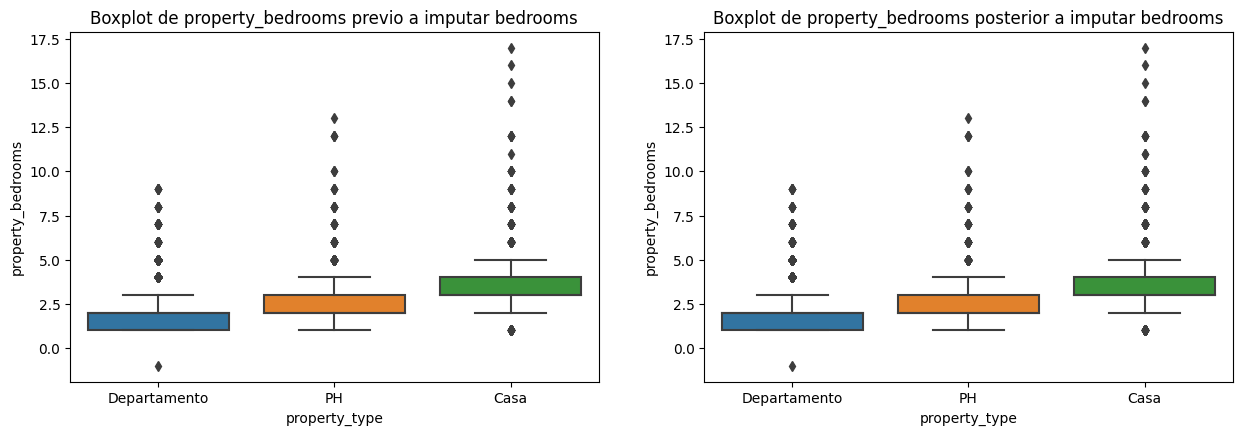

In [223]:
plt.figure(figsize=(15,10))
plt.subplot(221)
sns.boxplot(x=viviendas_caba_train.property_type, y=viviendas_caba_train.property_bedrooms).set(title = 'Boxplot de property_bedrooms previo a imputar bedrooms' )

#IMPUTAMOS
viviendas_caba_train.loc[sin_bedroom_con_room.index] = sin_bedroom_con_room 

plt.subplot(222)
sns.boxplot(x=viviendas_caba_train.property_type, y=viviendas_caba_train.property_bedrooms).set(title = 'Boxplot de property_bedrooms posterior a imputar bedrooms' )
plt.show()

Vemos que luego de imputar los dormitorios a base de las habitaciones no cambió la distribucion de las variables.

In [224]:
print(f'Cantidad de dormitorios faltantes: {viviendas_caba_train.property_bedrooms.isna().sum()}')
viviendas_caba_train[viviendas_caba_train.index == 27438]

Cantidad de dormitorios faltantes: 344


start_date   end_date    latitud   longitud  barrio property_type  \
27438 2021-12-03 2022-01-27 -34.645625 -58.459408  Flores  Departamento   

       property_rooms  property_bedrooms  property_surface_total  \
27438             1.0                1.0                    29.0   

       property_surface_covered  property_price  \
27438                      29.0         63000.0   

                                          property_title  
27438  Departamento a estrenar - Edificio con ameniti...

##### Imputamos rooms a base de bedrooms:

Realizamos el mismo procedimiento para los bedrooms.

In [225]:
sin_room_con_bedroom = viviendas_caba_train[viviendas_caba_train.property_rooms.isna() & viviendas_caba_train.property_bedrooms.notna()].copy()

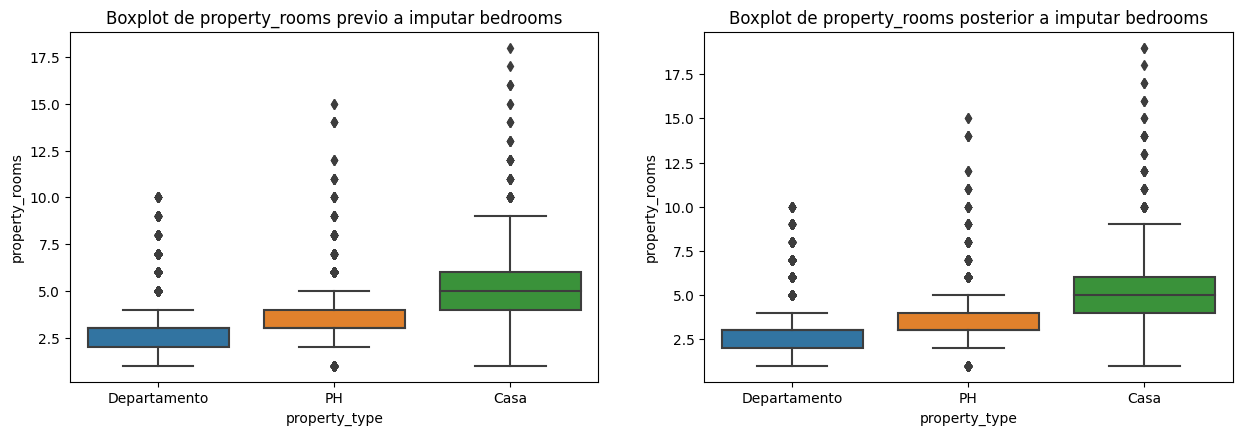

In [226]:
sin_room_con_bedroom.property_rooms = ((sin_room_con_bedroom.property_bedrooms-B0_e)/B1_e).round()

plt.figure(figsize=(15,10))
plt.subplot(221)
sns.boxplot(x=viviendas_caba_train.property_type, y=viviendas_caba_train.property_rooms).set(title = 'Boxplot de property_rooms previo a imputar bedrooms' )

#imputamos
viviendas_caba_train.loc[sin_room_con_bedroom.index] = sin_room_con_bedroom

plt.subplot(222)
sns.boxplot(x=viviendas_caba_train.property_type, y=viviendas_caba_train.property_rooms).set(title = 'Boxplot de property_rooms posterior a imputar bedrooms' )
plt.show()


##### Tratamos viviendas con más dormitorios que ambientes:

Decidimos que en caso que ocurra esto la cantidad de ambientes será igual a la cantidad de habitaciones

In [227]:
mas_bedrooms_que_rooms = viviendas_caba_train[viviendas_caba_train.property_bedrooms > viviendas_caba_train.property_rooms].copy()
viviendas_caba_train.loc[viviendas_caba_train.index.isin(mas_bedrooms_que_rooms.index), 'property_rooms'] = mas_bedrooms_que_rooms['property_bedrooms']

##### Viviendas sin rooms ni bedrooms

Vemos que tenemos aun todavia algunos datos faltantes de las cantidades de cuartos faltantes, como son relativamente pocos, y nos parece que imputar, usando la media o mediana, haria mas de que bien debido a la alta variabilidad de los datos, decidimos dropearlos.

In [228]:
sin_room_ni_bedroom = viviendas_caba_train[viviendas_caba_train.property_rooms.isna() & viviendas_caba_train.property_bedrooms.isna()]
sin_room_ni_bedroom.shape

(344, 12)

In [229]:
def transformacion_drop_viviendas_sin_rooms_ni_bedrooms(df_viviendas, sin_room_ni_bedroom):
    df_viviendas.drop(sin_room_ni_bedroom.index, axis=0,inplace=True)
transformacion_drop_viviendas_sin_rooms_ni_bedrooms(viviendas_caba_train, sin_room_ni_bedroom)

Volvemos a graficar los valores faltantes por columna para mostrar el progreso.

<AxesSubplot: title={'center': 'Porcentaje de datos faltantes por categoria'}, xlabel='Categoria', ylabel='Porcentaje'>

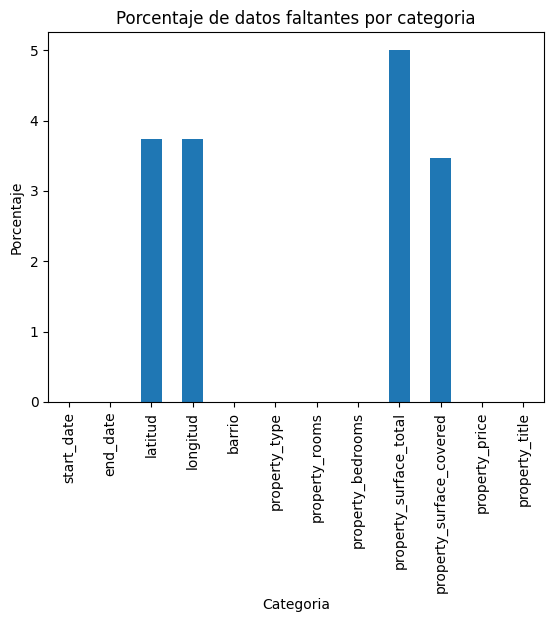

In [230]:
((viviendas_caba_train.isna().sum())/viviendas_caba_train.shape[0]*100).plot.bar(xlabel = 'Categoria', ylabel = 'Porcentaje', title = 'Porcentaje de datos faltantes por categoria')

#### Analizamos y eliminamos outliers de superficies

Primero hacemos un boxplot de ambas variables para ver valores atípicos.

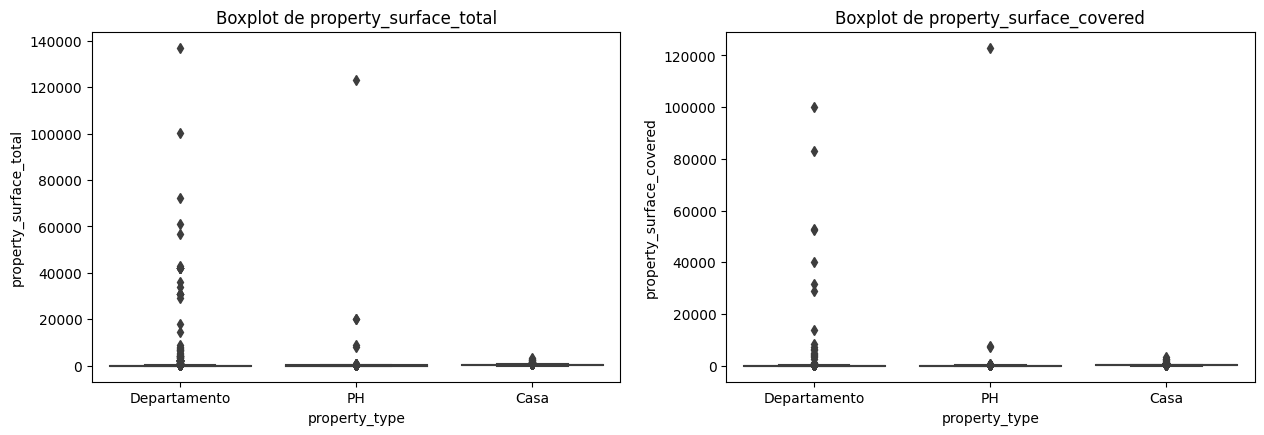

In [231]:
plt.figure(figsize=(15,10))
plt.subplot(221)
sns.boxplot(x=viviendas_caba_train.property_type, y=viviendas_caba_train.property_surface_total).set(title = 'Boxplot de property_surface_total' )
plt.subplot(222)
sns.boxplot(x=viviendas_caba_train.property_type, y=viviendas_caba_train.property_surface_covered).set(title = 'Boxplot de property_surface_covered' )
plt.show()



Suponiendo que todas estas viviendas estan dentro de CABA, nos parece razonable que todas aquellas que tengan mas de 1/3 hectarea de superficie total o que tengan mas superficie cubierta que total son valores atipícos por lo que las eliminamos.

In [232]:
def transformacion_drop_viviendas_grandes(df_viviendas):
    df_viviendas.drop(df_viviendas[(df_viviendas.property_surface_total > 3000) | (df_viviendas.property_surface_total < df_viviendas.property_surface_covered)].index, axis=0, inplace=True)
transformacion_drop_viviendas_grandes(viviendas_caba_train)

Volvemos a graficar:

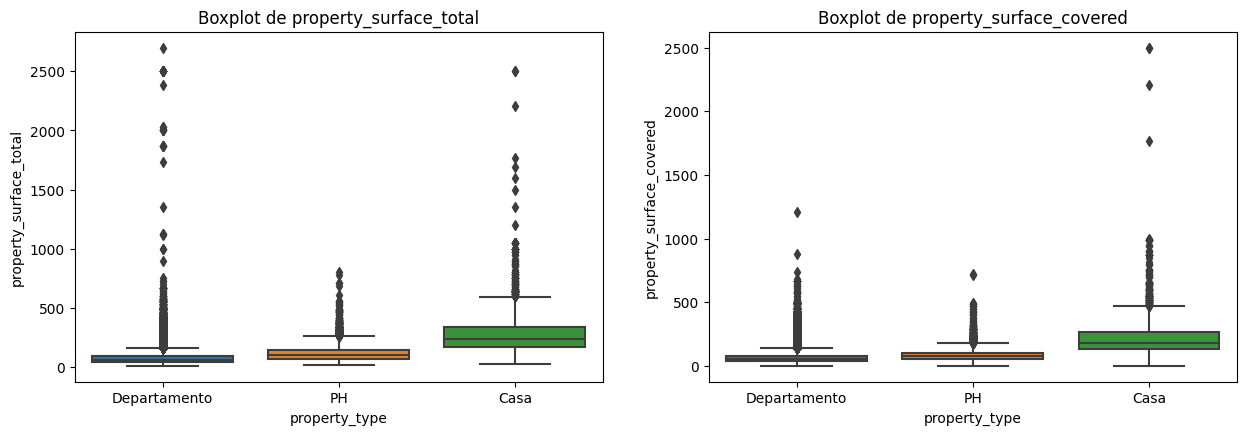

In [233]:
plt.figure(figsize=(15,10))
plt.subplot(221)
sns.boxplot(x=viviendas_caba_train.property_type, y=viviendas_caba_train.property_surface_total).set(title = 'Boxplot de property_surface_total' )
plt.subplot(222)
sns.boxplot(x=viviendas_caba_train.property_type, y=viviendas_caba_train.property_surface_covered).set(title = 'Boxplot de property_surface_covered' )
plt.show()

##### Superficie total:

Suponiendo que todas estas viviendas estan dentro de CABA, nos parece razonable que todas aquellos departamentos o PHs de más de 1000m^2 de superficie total o aquellos cuya superficie cubierta sea menos de un 20% de la total son atípicos. En cuanto a las casas tomamos como atípicas aquellas que tengan mas de 2000m^2.  
A su vez, tambien vamos a tener en cuenta aquellas propiedades que tengan menos de 10 metros cuadrados de superficie total (no vivimos en Tokyo).

[Text(0.5, 1.0, 'Boxplot de property_surface_total posterior a borrar')]

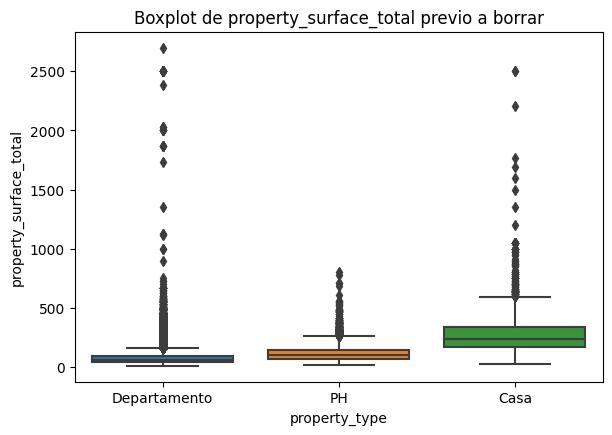

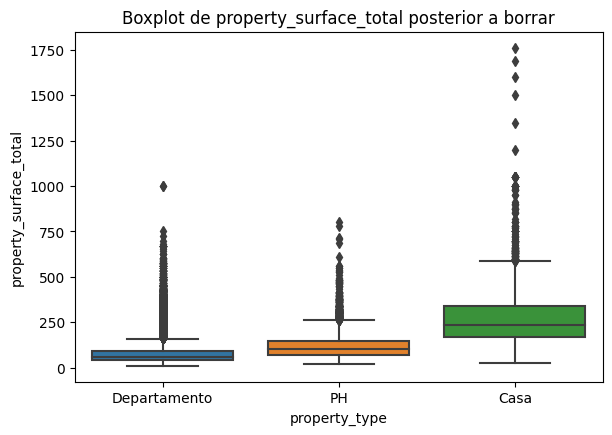

In [234]:
def obtener_viviendas_a_borrar_por_superfice_total(df_viviendas):
    deptos_a_borrar = df_viviendas[(df_viviendas.property_type == 'Departamento') & ((df_viviendas.property_surface_covered <  0.2*df_viviendas.property_surface_total) | (df_viviendas.property_surface_total > 1000) )]
    ph_a_borrar = df_viviendas[(df_viviendas.property_type == 'PH') & (df_viviendas.property_surface_total > 1000)]
    casas_a_borrar =  df_viviendas[(df_viviendas.property_type == 'Casa') & (df_viviendas.property_surface_total >2000)]
    viviendas_con_sup_total_chica = df_viviendas[(df_viviendas.property_surface_total < 10)]

    return pd.concat([deptos_a_borrar, ph_a_borrar, casas_a_borrar, viviendas_con_sup_total_chica])

viviendas_a_borrar = obtener_viviendas_a_borrar_por_superfice_total(viviendas_caba_train)

plt.figure(figsize=(15,10))
plt.subplot(221)
sns.boxplot(x=viviendas_caba_train.property_type, y=viviendas_caba_train.property_surface_total).set(title = 'Boxplot de property_surface_total previo a borrar' )

#BORRAMOS
viviendas_caba_train.drop(viviendas_a_borrar.index, axis=0,inplace=True)

plt.figure(figsize=(15,10))
plt.subplot(222)
sns.boxplot(x=viviendas_caba_train.property_type, y=viviendas_caba_train.property_surface_total).set(title = 'Boxplot de property_surface_total posterior a borrar' )

##### Superficie cubierta:

Suponiendo que todas estas viviendas estan dentro de caba, nos parece razonable que todas aquellas casa o PHs de más de 1000m^2 de superficie cubierta son atípicos al igual que los departamentos con superficies cubiertas mayores a 800m^2.
De manera analoga a superficie total, vamos a eliminar tambien aquellas propiedades que tengan menos de 10 metros cuadrados de superficie cubierta.

[Text(0.5, 1.0, 'Boxplot de property_surface_covered posterior a borrar')]

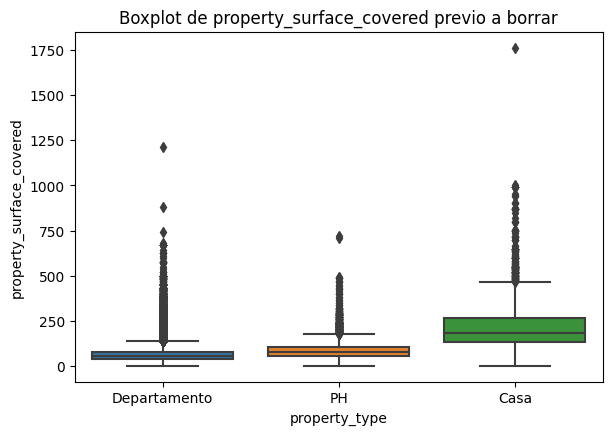

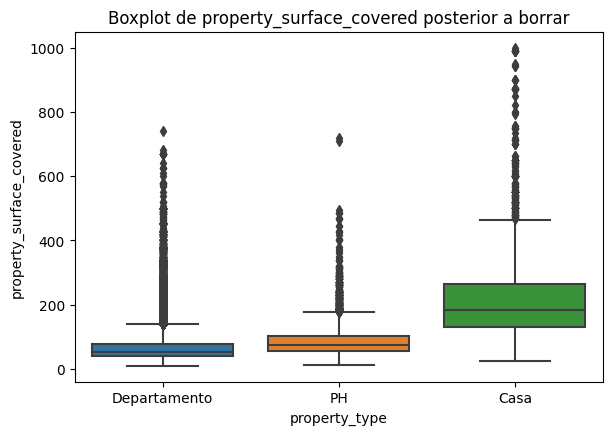

In [235]:
def obtener_viviendas_a_borrar_por_superfice_cubierta(df_viviendas):
    deptos_a_borrar = df_viviendas[(df_viviendas.property_type == 'Departamento') & ((df_viviendas.property_surface_covered > 800) )]
    ph_a_borrar = df_viviendas[(df_viviendas.property_type == 'PH') & (df_viviendas.property_surface_covered > 1000)]
    casas_a_borrar =  df_viviendas[(df_viviendas.property_type == 'Casa') & (df_viviendas.property_surface_covered >1000)]

    viviendas_con_sup_cub_chica = df_viviendas[(df_viviendas.property_surface_covered < 10)]

    return pd.concat([deptos_a_borrar, ph_a_borrar, casas_a_borrar, viviendas_con_sup_cub_chica])

viviendas_a_borrar = obtener_viviendas_a_borrar_por_superfice_cubierta(viviendas_caba_train)

plt.figure(figsize=(15,10))
plt.subplot(221)
sns.boxplot(x=viviendas_caba_train.property_type, y=viviendas_caba_train.property_surface_covered).set(title = 'Boxplot de property_surface_covered previo a borrar' )

viviendas_caba_train.drop(viviendas_a_borrar.index, axis=0,inplace=True)

plt.figure(figsize=(15,10))
plt.subplot(222)
sns.boxplot(x=viviendas_caba_train.property_type, y=viviendas_caba_train.property_surface_covered).set(title = 'Boxplot de property_surface_covered posterior a borrar' )

#### Analizamos y eliminamos outliers de precios

[Text(0.5, 1.0, 'Boxplot de property_price')]

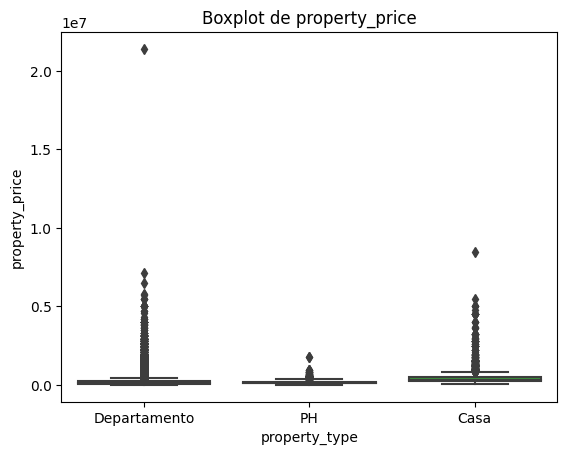

In [236]:
sns.boxplot(x=viviendas_caba_train.property_type, y=viviendas_caba_train.property_price).set(title = 'Boxplot de property_price' )


Comenzamos eliminando propiedades con precios atipicos

[Text(0.5, 1.0, 'Boxplot de property_price')]

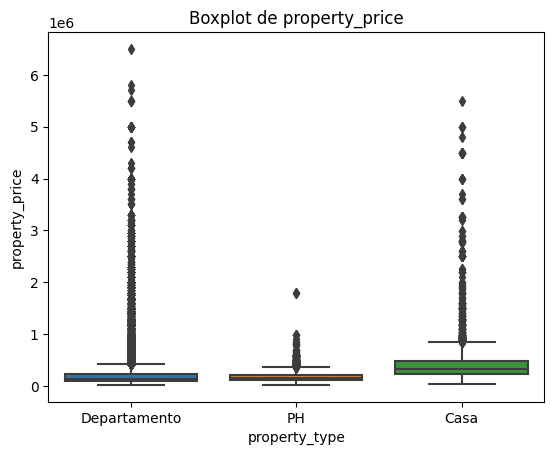

In [237]:
viviendas_caba_train.drop(viviendas_caba_train[(viviendas_caba_train.property_price > 7000000) | (viviendas_caba_train.property_price < 20000)].index, axis=0, inplace=True)
sns.boxplot(x=viviendas_caba_train.property_type, y=viviendas_caba_train.property_price).set(title = 'Boxplot de property_price' )

Eliminamos propiedades con precios superiores a 1000000 dólares que tengan relaciones ilógicas entre sus variables. Por ejemplo muy pocos ambientes o superficies muy chicas

[Text(0.5, 1.0, 'Boxplot de property_price posterior a borrar')]

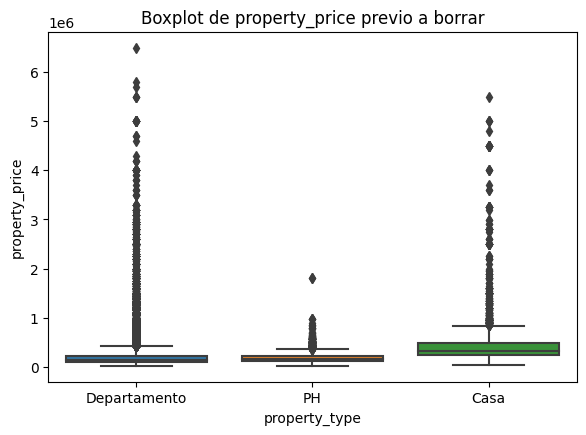

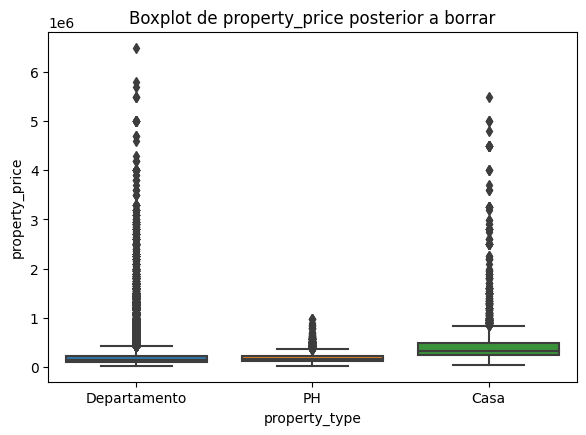

In [238]:
def obtener_viviendas_a_borrar_por_precios(df_viviendas):
    deptos_a_borrar = df_viviendas[(df_viviendas.property_type == 'Departamento') & (df_viviendas.property_price > 1000000) & (df_viviendas.property_surface_total < 100)]
    ph_a_borrar = df_viviendas[(df_viviendas.property_type == 'PH') & (df_viviendas.property_price > 1000000)]
    casas_a_borrar =  df_viviendas[(df_viviendas.property_type == 'Casa') & (df_viviendas.property_price > 1000000) & ((df_viviendas.property_surface_total < 200) | (df_viviendas.property_rooms < 4))]

    return pd.concat([deptos_a_borrar, ph_a_borrar, casas_a_borrar])

viviendas_a_borrar = obtener_viviendas_a_borrar_por_precios(viviendas_caba_train)

plt.figure(figsize=(15,10))
plt.subplot(221)
sns.boxplot(x=viviendas_caba_train.property_type, y=viviendas_caba_train.property_price).set(title = 'Boxplot de property_price previo a borrar' )

#BORRAMOS
viviendas_caba_train.drop(viviendas_a_borrar.index, axis=0,inplace=True)

plt.figure(figsize=(15,10))
plt.subplot(222)
sns.boxplot(x=viviendas_caba_train.property_type, y=viviendas_caba_train.property_price).set(title = 'Boxplot de property_price posterior a borrar' )

#### Intentamos buscar relacion entre superficie y dormitorios para completar valores faltantes:

Para ver si podemos completar los datos que nos faltan de property_surface_covered, lo que hacemos es fijarnos si hay alguna relacion entre la cantidad de cuartos y la superficie cubierta, dado un tipo de propiedad, ya sea casa, departamento o PH. 

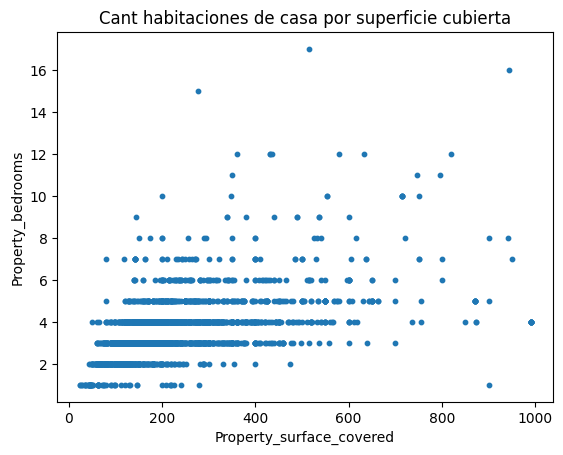

In [239]:
cant_hab_casa = viviendas_caba_train[viviendas_caba_train.property_surface_covered < 1000]
grf_bedrooms_cover_surface_casa = cant_hab_casa[cant_hab_casa.property_type=='Casa'].plot.scatter(x="property_surface_covered", y="property_bedrooms", s=10).set(title="Cant habitaciones de casa por superficie cubierta",xlabel='Property_surface_covered',ylabel='Property_bedrooms') 


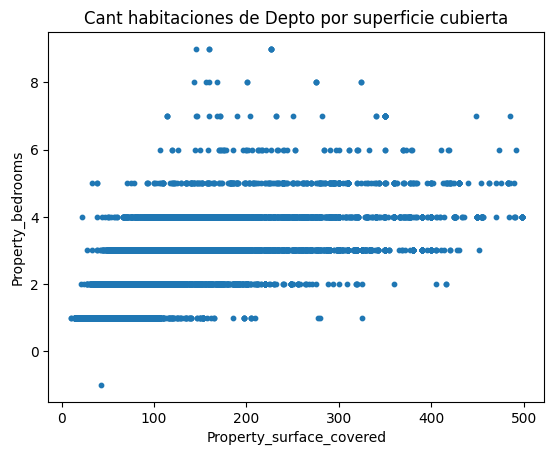

In [240]:
cant_hab_depto = viviendas_caba_train[(viviendas_caba_train.property_surface_covered < 500) & (viviendas_caba_train.property_bedrooms < 15)]

grf_bedrooms_cover_surface_depto  = cant_hab_depto[cant_hab_depto.property_type=='Departamento'].plot.scatter(x="property_surface_covered", y="property_bedrooms", s=10).set(title="Cant habitaciones de Depto por superficie cubierta",xlabel='Property_surface_covered',ylabel='Property_bedrooms') 


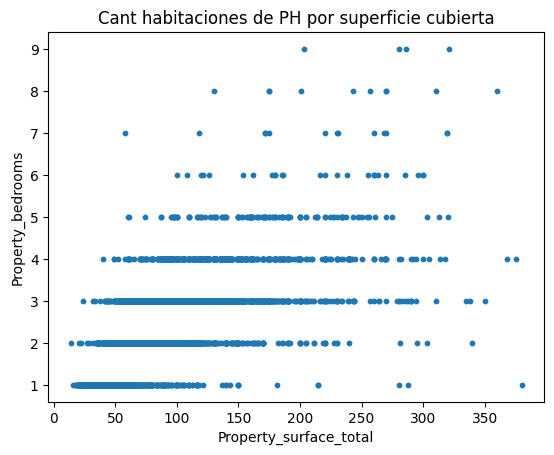

In [241]:
cant_hab_ph = viviendas_caba_train[(viviendas_caba_train.property_surface_covered < 400) & (viviendas_caba_train.property_bedrooms < 10)]
grf_bedrooms_cover_surface_ph = cant_hab_ph[cant_hab_ph.property_type=='PH'].plot.scatter(x="property_surface_covered", y="property_bedrooms", s=10).set(title="Cant habitaciones de PH por superficie cubierta",xlabel='Property_surface_total',ylabel='Property_bedrooms') 

Despues de analizar los 3 graficos, no encontramos ninguna relacion lo suficientemente fuerte como para completar las superficies cubiertas con la cantidad de cuartos.

#### Reparamos superficie total y cubierta:

Como la relacion entre la superficie lineal y cubierta no es del todo lineal elegimos el algoritmo de MICE (Multiple Imputation by Chained Equations) que es iterativo y tiene en cuenta mas de una variable para predecir un valor

In [242]:
print(f'Valores faltantes de superficie total: {viviendas_caba_train.property_surface_total.isna().sum()}')
print(f'Valores faltantes de superficie cubierta: {viviendas_caba_train.property_surface_covered.isna().sum()}')

Valores faltantes de superficie total: 3712
Valores faltantes de superficie cubierta: 2582


Aplicamos MICE para completar valores faltantes de superficies:

In [243]:
def transformacion_imputar_superficie(df_viviendas):
    indices_sin_sup_tot = df_viviendas[df_viviendas.property_surface_total.isna()].index
    indices_sin_sup_cov = df_viviendas[df_viviendas.property_surface_covered.isna()].index

    columnas=['property_surface_total','property_surface_covered']
    imputar_nans_sup_total=df_viviendas[columnas].copy()

    lr = LinearRegression()
    imp = IterativeImputer(estimator=lr,missing_values=np.nan, max_iter=20, verbose=0, random_state=0) #imputation_order='roman'
    nans_imputados=imp.fit_transform(imputar_nans_sup_total)
    dfnu = pd.DataFrame(nans_imputados, columns = columnas)
    df_viviendas.reset_index(drop = False, inplace = True)
    df_viviendas['property_surface_covered'] = dfnu.property_surface_covered.round(0)
    df_viviendas['property_surface_total'] = dfnu.property_surface_total.round(0)
    return indices_sin_sup_tot , indices_sin_sup_cov

indices_sin_sup_tot , indices_sin_sup_cov = transformacion_imputar_superficie(viviendas_caba_train)
viviendas_caba_train.isna().sum()

index                          0
start_date                     0
end_date                       0
latitud                     2772
longitud                    2772
barrio                         0
property_type                  0
property_rooms                 0
property_bedrooms              0
property_surface_total         0
property_surface_covered       0
property_price                 0
property_title                 0
dtype: int64

Hacemos chequeo visual para ver si los datos completados tienen sentido

In [244]:
viviendas_caba_train[viviendas_caba_train['index'].isin(indices_sin_sup_tot)].head(2)[['property_surface_total','property_surface_covered']]

property_surface_total  property_surface_covered
4                     91.0                      78.0
21                  1089.0                     943.0

In [245]:
viviendas_caba_train[viviendas_caba_train['index'].isin(indices_sin_sup_cov)].head(2)[['property_surface_total','property_surface_covered']]


property_surface_total  property_surface_covered
53                    56.0                      50.0
80                    32.0                      31.0

Vemos que los datos tienen sentido

In [246]:
viviendas_caba_train.drop(columns='index', inplace=True)

#### Imputamos latitud y longitud a viviendas por barrio:

Comenzamos obteniendo el centroide de cada barrio.

C:\Users\forte\AppData\Local\Temp\ipykernel_4064\557041595.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  poly["centroide_x"] = poly["geometry"].centroid.x.round(8)
C:\Users\forte\AppData\Local\Temp\ipykernel_4064\557041595.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  poly["centroide_y"] = poly["geometry"].centroid.y.round(8)


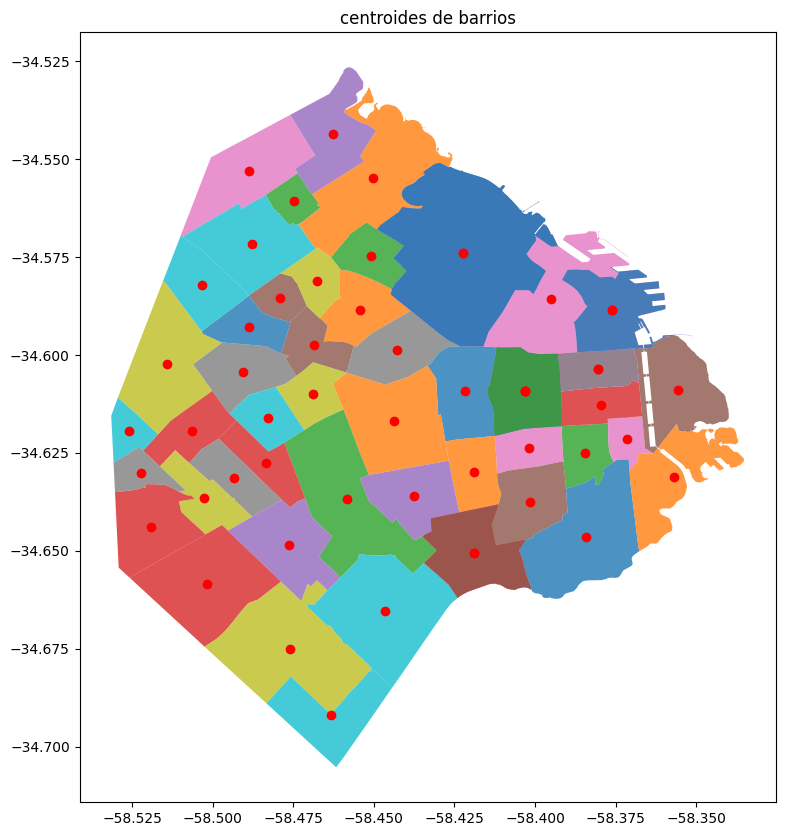

In [247]:
poly["centroide_x"] = poly["geometry"].centroid.x.round(8)
poly["centroide_y"] = poly["geometry"].centroid.y.round(8)


#Grafico 
fig, ax = plt.subplots(figsize=(10,10))
poly.plot(ax=ax,column='BARRIO',alpha=0.8).set(title = 'centroides de barrios' )
plt.scatter(poly.centroide_x,poly.centroide_y,color='red')

Imputamos a vivienda sin latitud o logitud la correspondiente al centroide de su barrio.

In [248]:
def obtener_sin_lat_sin_long(df_viviendas):
    sin_lat= df_viviendas[df_viviendas.latitud.isna()].copy()
    sin_long = df_viviendas[df_viviendas.longitud.isna()].copy()

    for index in poly.index:
        barrio = poly.iloc[index, 0].title()
        lat_y = poly.iloc[index, 7]
        long_x = poly.iloc[index, 6]
        sin_lat.loc[sin_lat.barrio.str.title() == barrio, 'latitud'] = lat_y
        sin_long.loc[sin_long.barrio.str.title() == barrio, 'longitud'] = long_x
    return sin_lat, sin_long


Imputamos latitudes y longitudes:

In [249]:
def transformacion_imputar_lat_long(df_viviendas):
    sin_lat , sin_long = obtener_sin_lat_sin_long(df_viviendas)
    df_viviendas.loc[df_viviendas.index.isin(sin_lat.index), 'latitud'] = sin_lat.latitud
    df_viviendas.loc[df_viviendas.index.isin(sin_long.index), 'longitud'] = sin_long.longitud
    return sin_lat, sin_long
sin_lat, sin_long = transformacion_imputar_lat_long(viviendas_caba_train)

[Text(0.5, 1.0, 'coordenadas completadas gracias a barrio')]

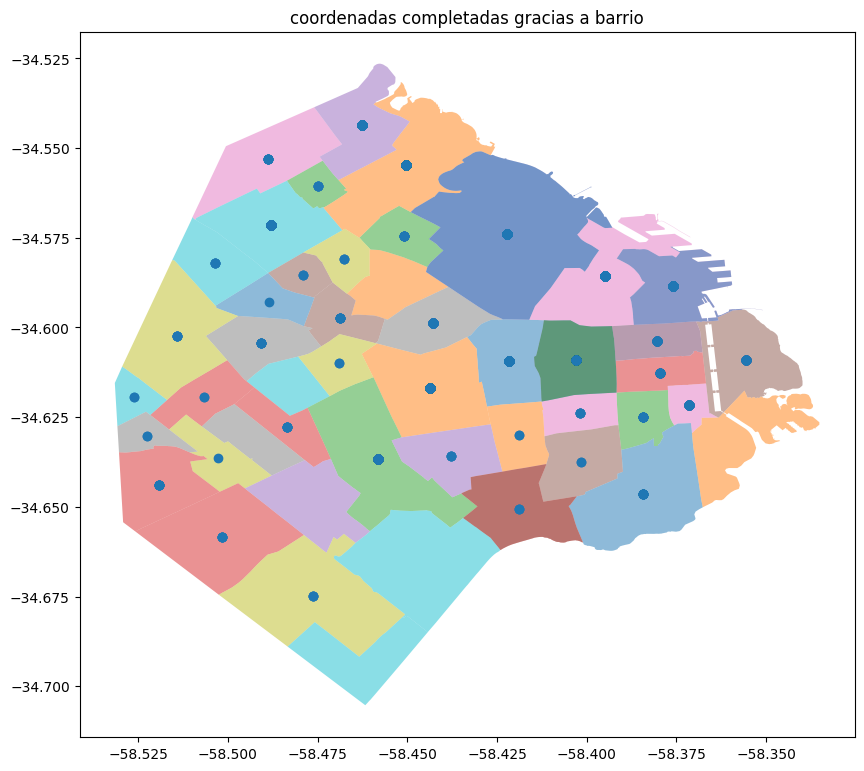

In [250]:
mapa_coordenadas_completadas = gp.GeoDataFrame(sin_long, geometry=gp.points_from_xy(sin_long.longitud, sin_lat.latitud))
fig, ax = plt.subplots(figsize=(10,10))
poly.plot(ax=ax,column='BARRIO',alpha=0.5)
mapa_coordenadas_completadas.plot(ax=ax).set(title = 'coordenadas completadas gracias a barrio' )

In [251]:
print(f'cantidad de viviendas sin barrio, sin latitud y sin longitud: {viviendas_caba_train[(viviendas_caba_train.latitud.isna()) | (viviendas_caba_train.longitud.isna())].shape[0]}')

cantidad de viviendas sin barrio, sin latitud y sin longitud: 2


Vemos que casi no quedan viviendas sin coordenadas por lo que las eliminamos.

In [252]:
def transformacion_drop_lat_long(df_viviendas):
    df_viviendas.drop(df_viviendas[df_viviendas.latitud.isna()].index, axis=0, inplace=True)
transformacion_drop_lat_long(viviendas_caba_train)

In [253]:
viviendas_caba_train.isna().sum()

start_date                  0
end_date                    0
latitud                     0
longitud                    0
barrio                      0
property_type               0
property_rooms              0
property_bedrooms           0
property_surface_total      0
property_surface_covered    0
property_price              0
property_title              0
dtype: int64

### Análisis Exploratorio luego del Preprocesamiento de Datos

#### Datos faltantes:

In [254]:
viviendas_caba_train.isna().sum()

start_date                  0
end_date                    0
latitud                     0
longitud                    0
barrio                      0
property_type               0
property_rooms              0
property_bedrooms           0
property_surface_total      0
property_surface_covered    0
property_price              0
property_title              0
dtype: int64

Vemos que no tenemos datos faltantes en el dataset.

#### Análisis medidas de resumen de variables cuantitativas:

In [255]:
medidas_de_resumen = viviendas_caba_train.describe()
medidas_de_resumen.drop(['count' , 'std', 'min', 'max'], axis=0, inplace=True)
moda = viviendas_caba_train.mode()
moda.head(10)
moda.index = ['mode']

moda.drop(['barrio','property_type','property_title'], axis = 1, inplace = True) 

medidas_de_resumen = pd.concat([medidas_de_resumen, moda])
medidas_de_resumen

latitud   longitud  property_rooms  property_bedrooms  \
mean -34.595769 -58.438346          2.8233           1.900334   
25%  -34.615601 -58.465411          2.0000           1.000000   
50%  -34.595270 -58.438730          3.0000           2.000000   
75%  -34.576482 -58.408879          4.0000           3.000000   
mode -34.573855 -58.422342          3.0000           1.000000   

      property_surface_total  property_surface_covered  property_price  \
mean               90.976722                 77.940728   225084.688676   
25%                45.000000                 40.000000    95000.000000   
50%                65.000000                 57.000000   144000.000000   
75%               105.000000                 88.000000   235000.000000   
mode               50.000000                 40.000000   110000.000000   

     start_date   end_date  
mean        NaT        NaT  
25%         NaT        NaT  
50%         NaT        NaT  
75%         NaT        NaT  
mode 2021-12-16 2021-06-05

#### Análisis gráfico distribucion de variables cuantitativas

In [256]:
"""pairplot_fig_procesado = sns.pairplot(viviendas_caba_train, hue='property_type').figure
pairplot_fig_procesado.savefig('./Figures/paiplot_dataset_procesado')"""

"pairplot_fig_procesado = sns.pairplot(viviendas_caba_train, hue='property_type').figure\npairplot_fig_procesado.savefig('./Figures/paiplot_dataset_procesado')"

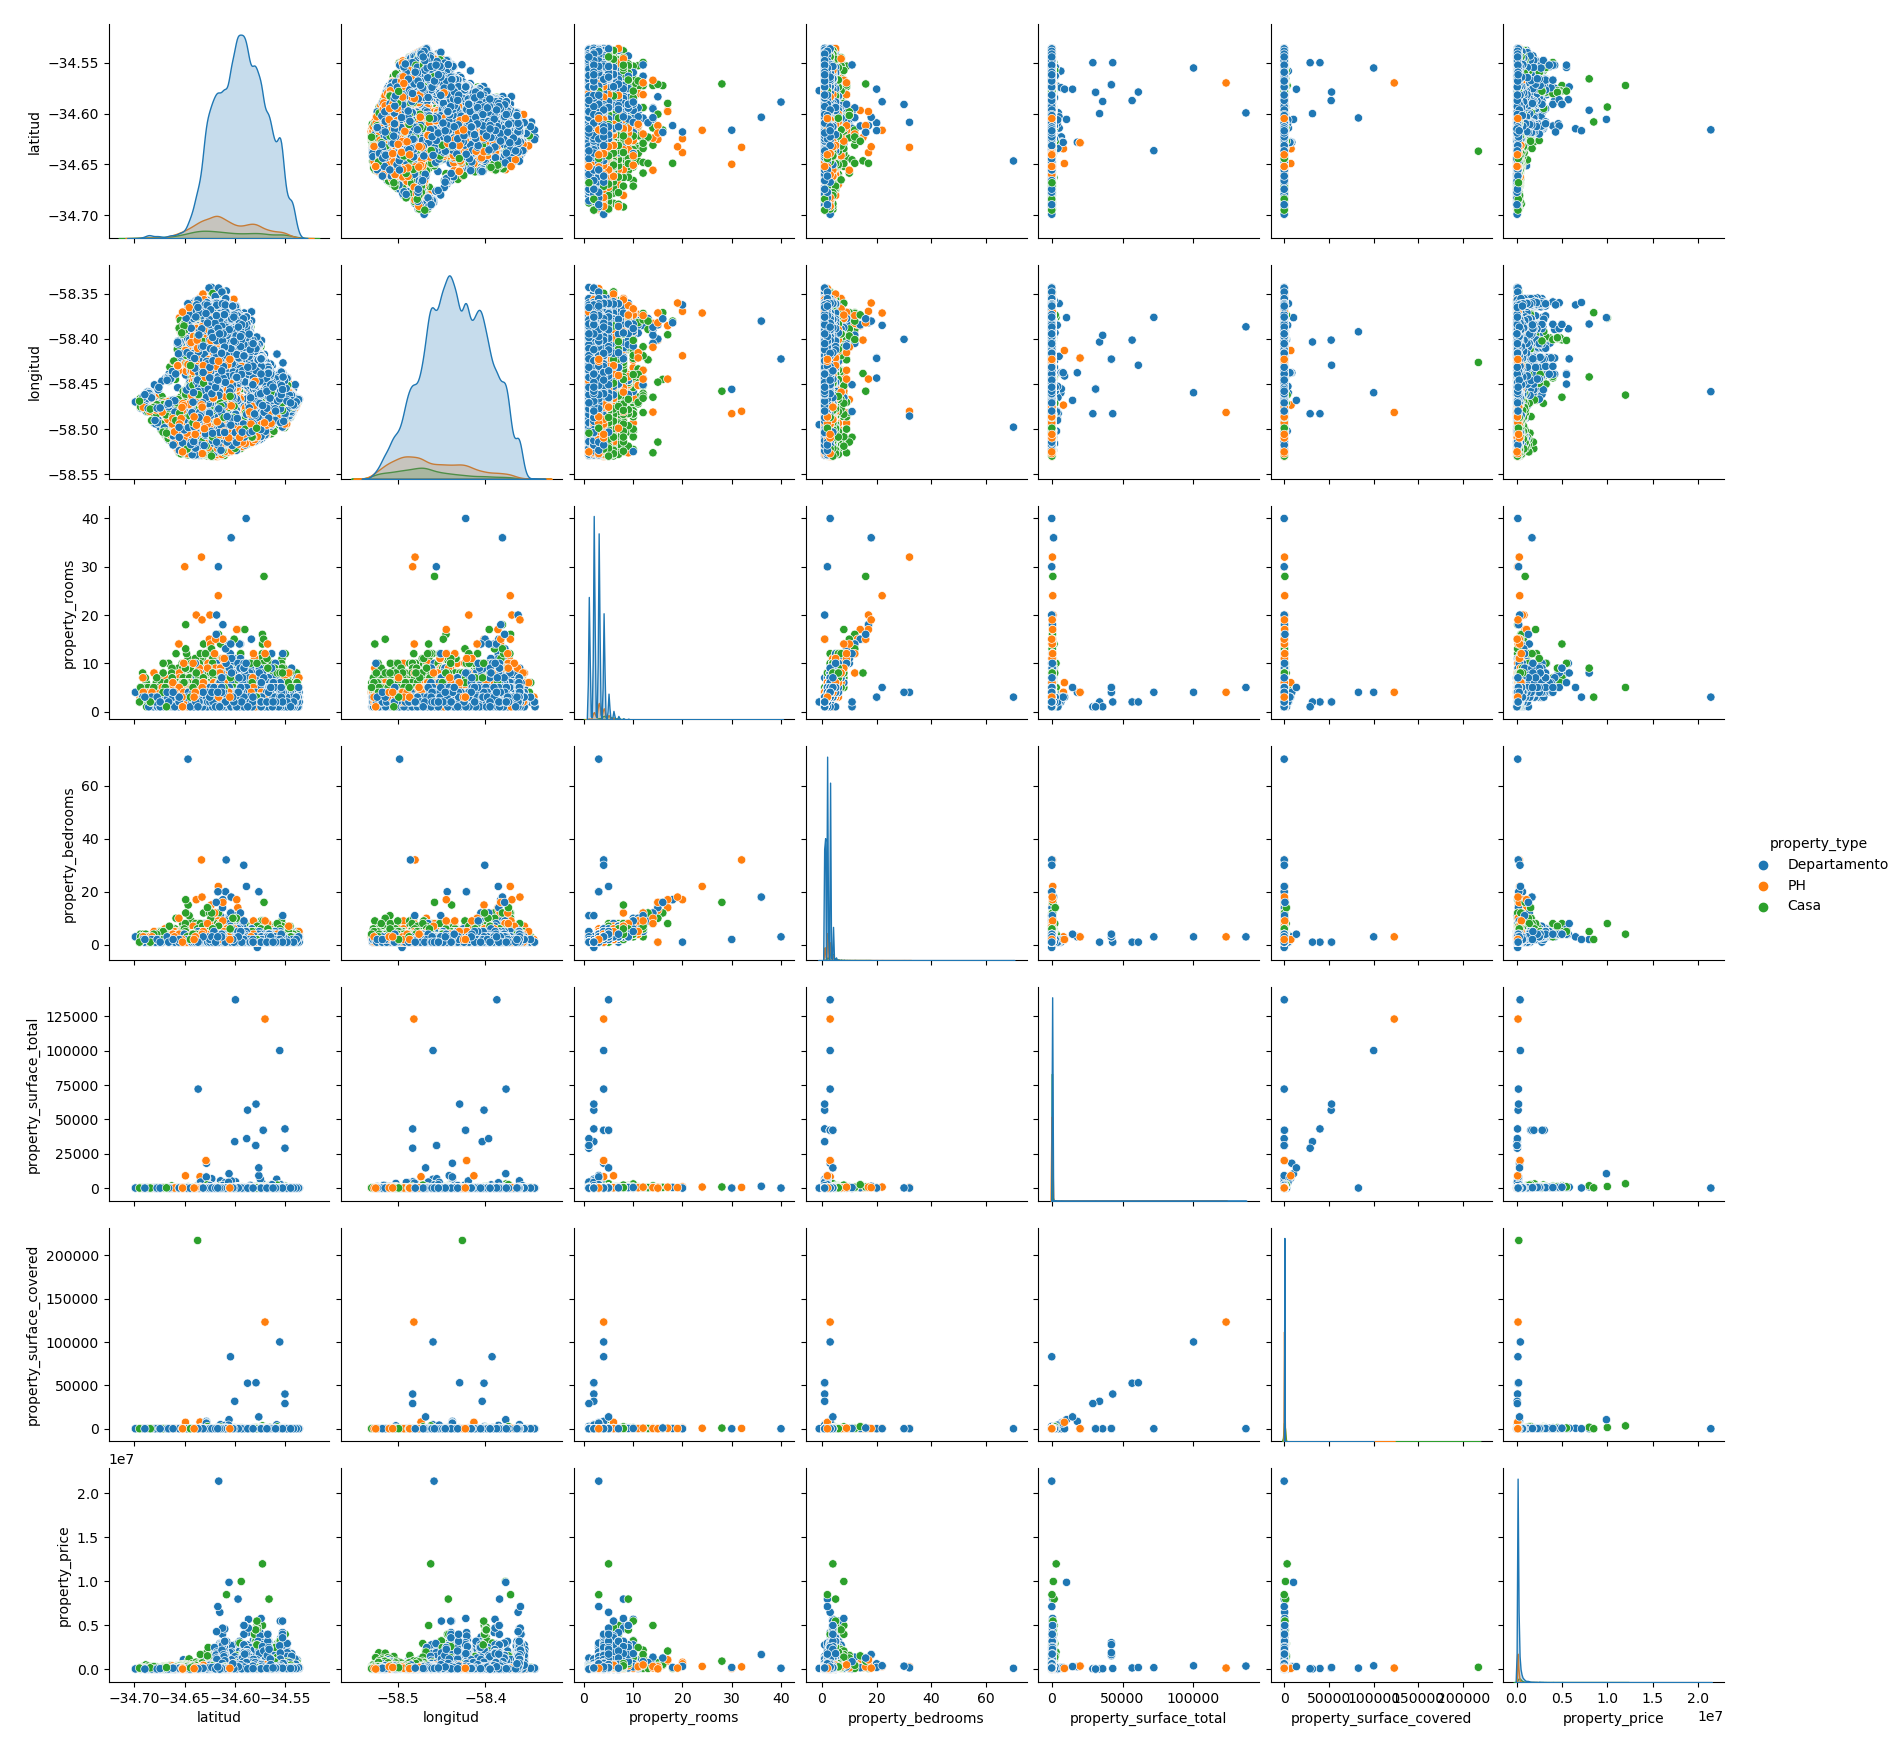

In [257]:
Image(filename = './Figures/paiplot_dataset_procesado.png', width=1500, height=1500)

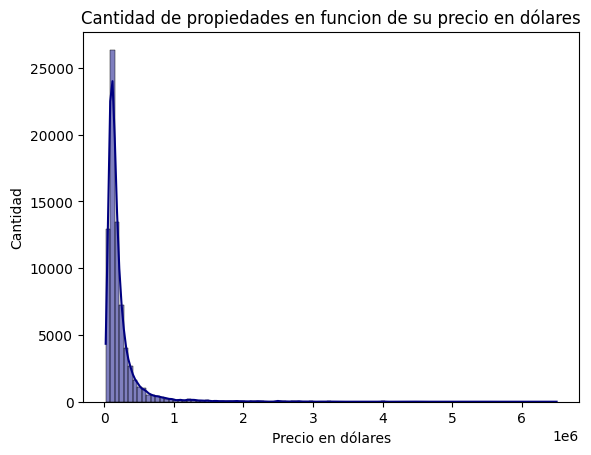

In [258]:
sns_hist = sns.histplot(data=viviendas_caba_train['property_price'], color='navy', kde=True, alpha = 0.5, bins=100).set(title="Cantidad de propiedades en funcion de su precio en dólares",xlabel="Precio en dólares",ylabel="Cantidad")

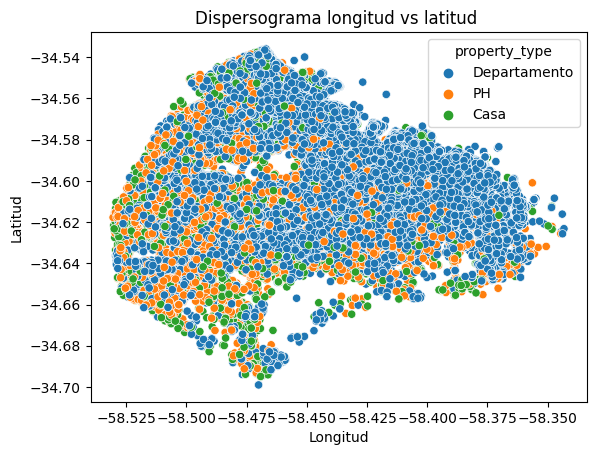

In [259]:
grf_long_lat = sns.scatterplot(data=viviendas_caba_train, x="longitud", y="latitud", hue='property_type').set(title="Dispersograma longitud vs latitud ",xlabel='Longitud',ylabel='Latitud')

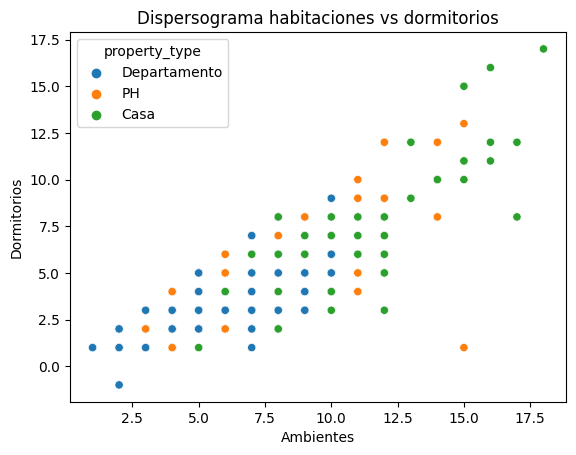

In [260]:
grf_dormitorios_por_habitaciones = sns.scatterplot(data=viviendas_caba_train, x="property_rooms", y="property_bedrooms", hue='property_type').set(title="Dispersograma habitaciones vs dormitorios",xlabel='Ambientes',ylabel='Dormitorios') 

<AxesSubplot: title={'center': 'Cantidad de ventas por mes'}, xlabel='Mes', ylabel='Cantidad de ventas'>

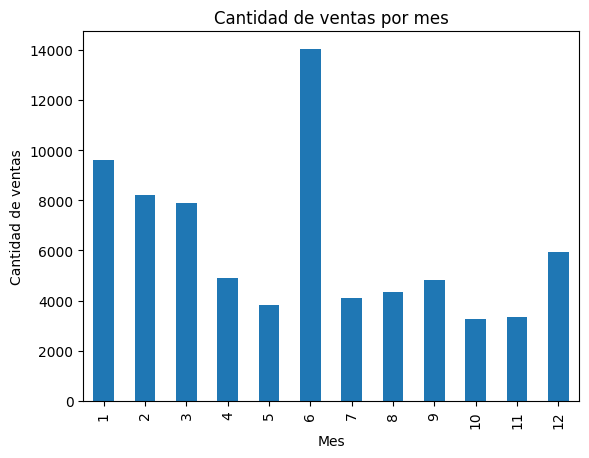

In [261]:
def ventas_por_mes(fila):
    return viviendas_caba_train.loc[fila].end_date.month

cantidad_de_ventas_por_mes = viviendas_caba_train.end_date.groupby(by=ventas_por_mes).count()
cantidad_de_ventas_por_mes.plot.bar(title="Cantidad de ventas por mes" , xlabel="Mes" , ylabel="Cantidad de ventas")

<AxesSubplot: title={'center': 'Ventas por mes'}, xlabel='Mes', ylabel='Dólares'>

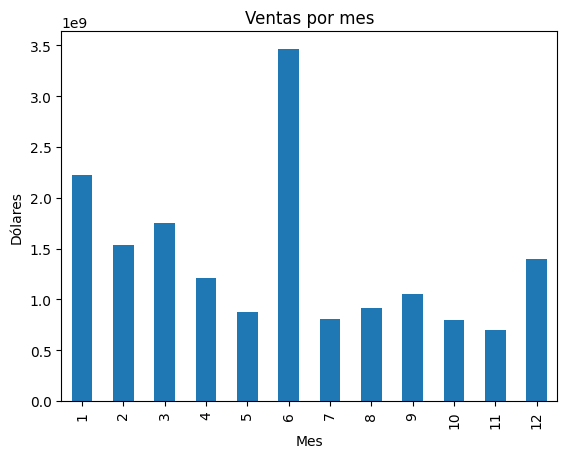

In [262]:
ventas_por_mes = viviendas_caba_train.groupby(by=ventas_por_mes).property_price.sum()
ventas_por_mes.plot.bar(title="Ventas por mes" , xlabel="Mes" , ylabel="Dólares")

<AxesSubplot: title={'center': 'Cantidad de viviendas por barrio'}, xlabel='Barrio', ylabel='Cantidad'>

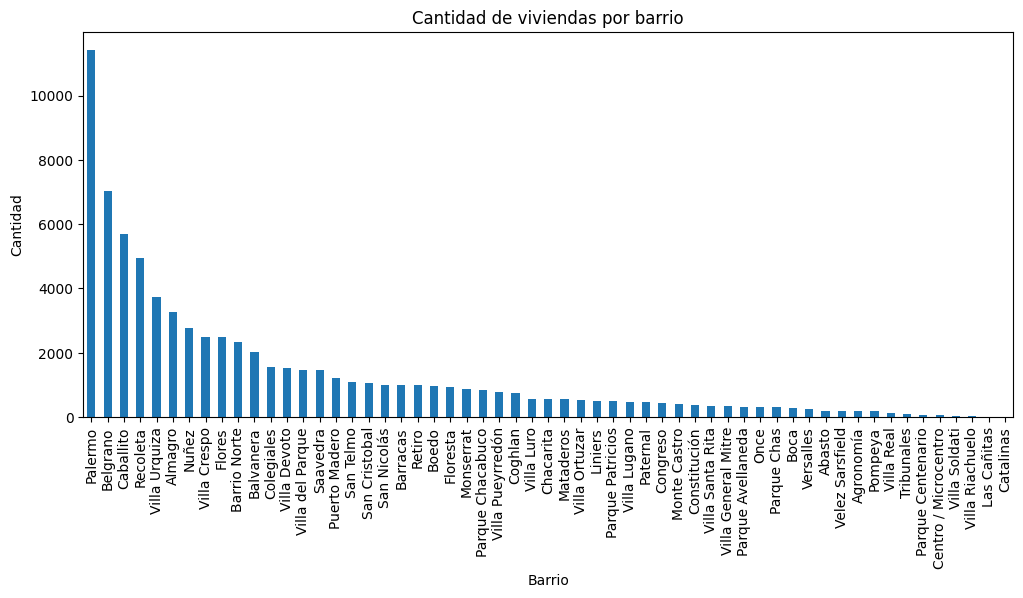

In [263]:
viviendas_caba_train.barrio.value_counts().plot.bar(figsize=(12,5),title="Cantidad de viviendas por barrio" , xlabel="Barrio" , ylabel="Cantidad")

<AxesSubplot: title={'center': 'Promedio de precios de m^2 por barrio'}, xlabel='Barrio', ylabel='Promedio de m^2'>

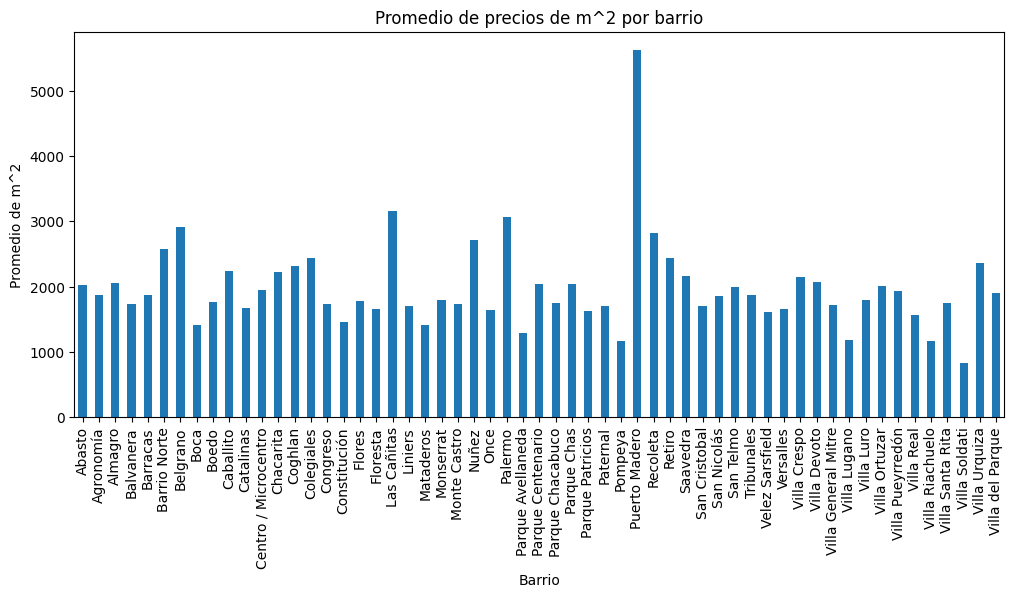

In [264]:
precio_m_2 = viviendas_caba_train['property_price'] /viviendas_caba_train['property_surface_total']
con_precio_por_m_2 = pd.DataFrame()
con_precio_por_m_2['barrio'] = viviendas_caba_train.copy().barrio
con_precio_por_m_2['precio_m^2'] = precio_m_2

con_precio_por_m_2.groupby('barrio')['precio_m^2'].mean().plot.bar(figsize=(12,5), title="Promedio de precios de m^2 por barrio" , xlabel="Barrio" , ylabel="Promedio de m^2")


<AxesSubplot: title={'center': 'Promedio de precios por barrio'}, xlabel='Barrio', ylabel='Promedio de precios'>

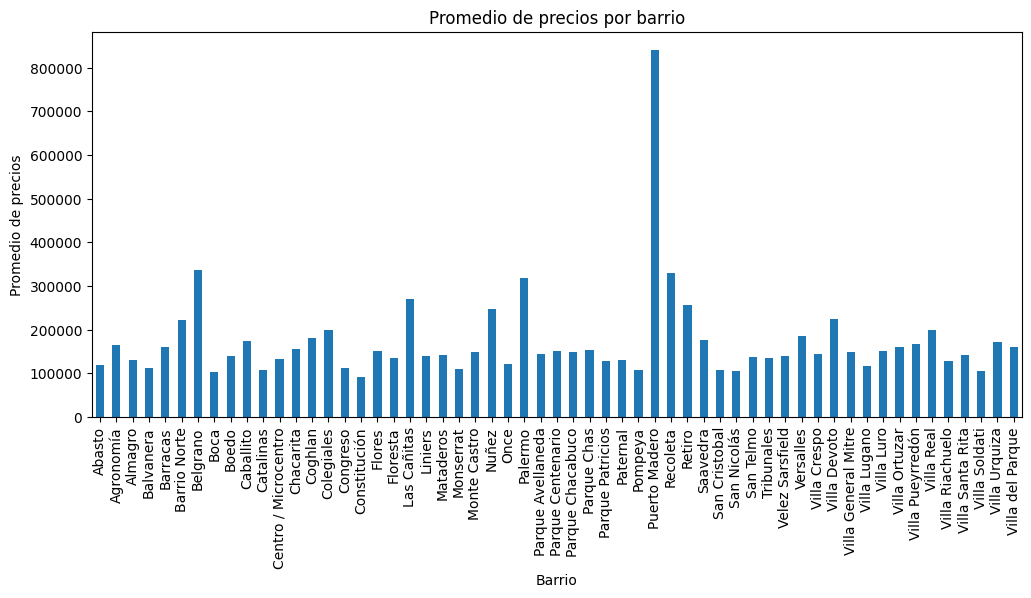

In [265]:
viviendas_caba_train.groupby('barrio')['property_price'].mean().plot.bar(figsize=(12,5), title="Promedio de precios por barrio" , xlabel="Barrio" , ylabel="Promedio de precios")

<AxesSubplot: title={'center': 'Promedio de superficie total por por barrio'}, xlabel='Barrio', ylabel='Promedio de superfiecie total'>

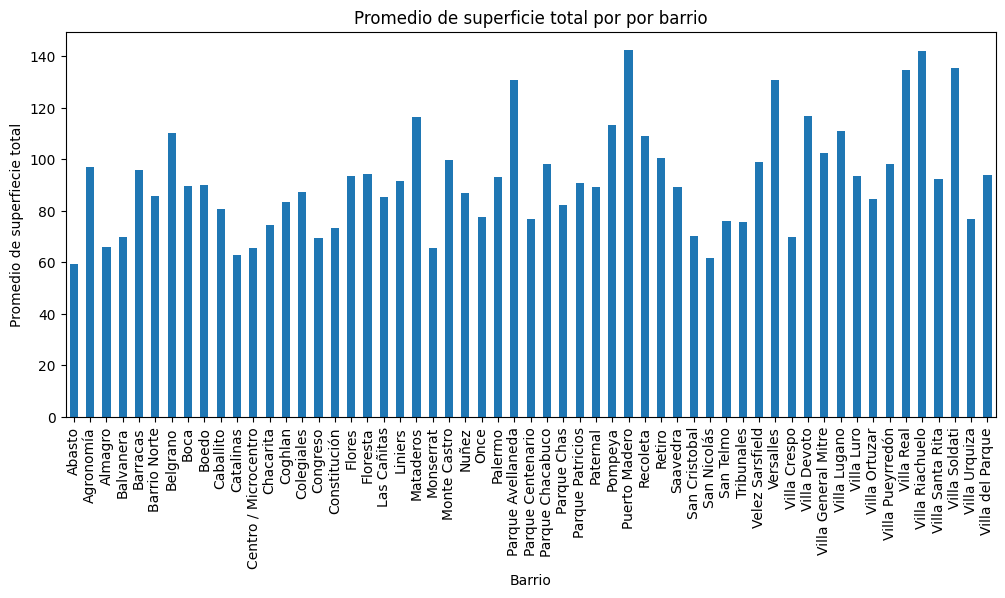

In [266]:
viviendas_caba_train.groupby('barrio')['property_surface_total'].mean().plot.bar(figsize=(12,5), title="Promedio de superficie total por por barrio" , xlabel="Barrio" , ylabel="Promedio de superfiecie total")

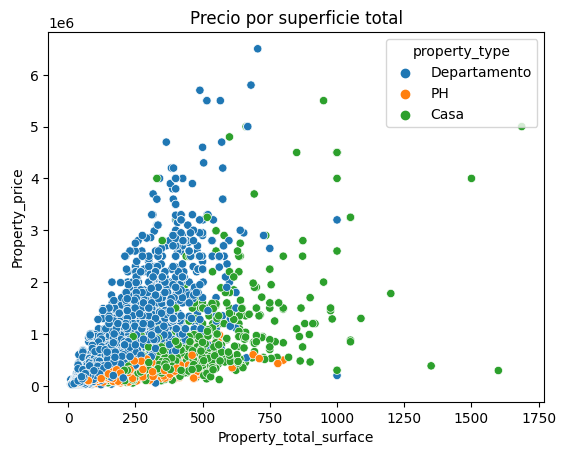

In [267]:
grf_precio_por_superficie = sns.scatterplot(data=viviendas_caba_train, x="property_surface_total", y="property_price", hue='property_type').set(title="Precio por superficie total",xlabel='Property_total_surface',ylabel='Property_price') 

C:\Users\forte\AppData\Local\Temp\ipykernel_4064\1206928485.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  matriz_correlacion=viviendas_caba_train.corr()


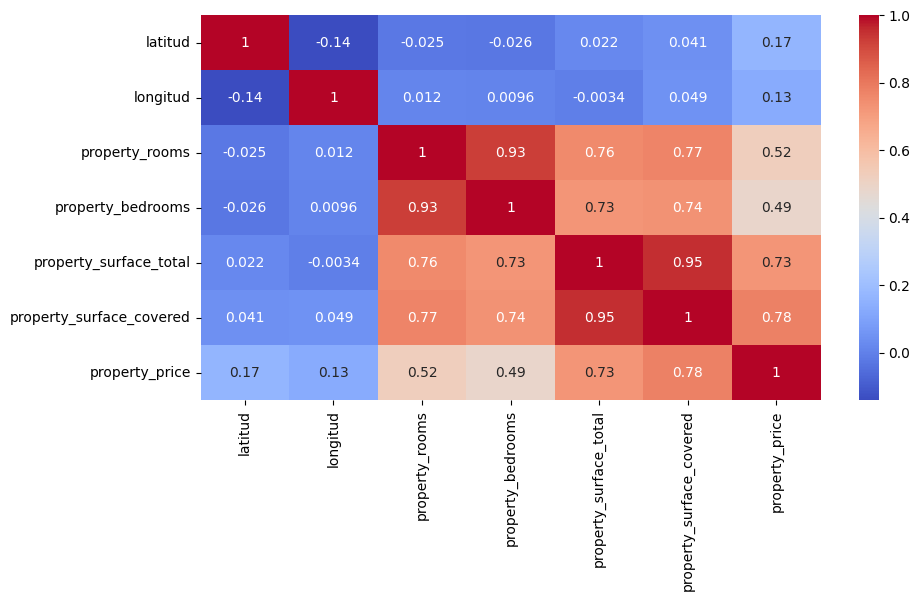

In [268]:
matriz_correlacion=viviendas_caba_train.corr()

plt.figure(figsize=(10,5))
sns.heatmap(matriz_correlacion, annot = True,cmap = 'coolwarm')
plt.show()

En relacion al primer grafico que obtuvimos de correlacion de variables, vemos que el prepocesamiento y la transformacion de datos genera un dataset con mejor correlacion.

#### Graficos sobre el mapa de tipo de propiedad

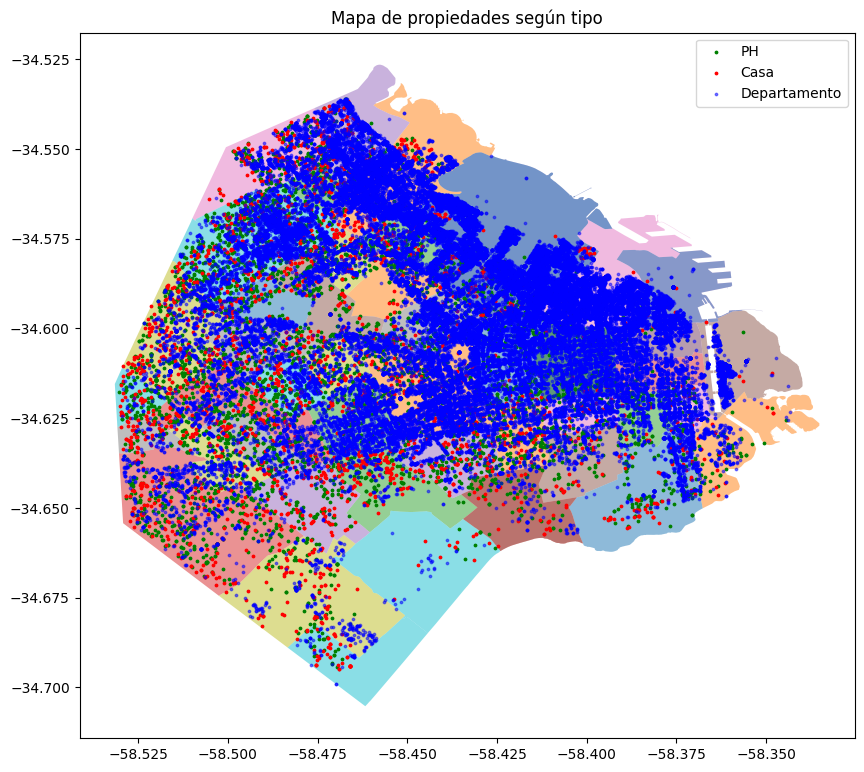

In [269]:
fig, ax = plt.subplots(figsize=(10,10))
poly.plot(ax=ax,column='BARRIO',alpha=0.5)
mapa_de_viviendas_en_caba = gp.GeoDataFrame(viviendas_caba_train, geometry=gp.points_from_xy(viviendas_caba_train.longitud, viviendas_caba_train.latitud))
mapa_de_viviendas_en_caba[mapa_de_viviendas_en_caba.property_type == 'PH'].plot(ax=ax,markersize=3, color='green', label='PH',alpha=1)
mapa_de_viviendas_en_caba[mapa_de_viviendas_en_caba.property_type == 'Casa'].plot(ax=ax,markersize=3, color='red', label='Casa',alpha=1)
mapa_de_viviendas_en_caba[mapa_de_viviendas_en_caba.property_type == 'Departamento'].plot(ax=ax,markersize=3, color='blue', label='Departamento',alpha=0.5).set(title="Mapa de propiedades según tipo") 
plt.legend()
plt.show()


### Aplicacion de transformaciones a datasets

Aplicamos todas las transformaciones obtenidas tras analizar el dataset de train, tanto al dataset de test como al dataset completo

In [270]:
def transformacion_drop_no_pertenecen_caba(df_viviendas, nombre_destino):
    con_lat_y_lon = obtener_lat_long(df_viviendas)
    #crear_mascara(df_viviendas, nombre_destino)
    viviendas_dentro_caba, viviendas_fuera_de_caba = separar_segun_esten_dentro_de_caba(df_viviendas, nombre_destino, con_lat_y_lon)
    df_viviendas.drop(viviendas_fuera_de_caba.index, axis=0, inplace=True)


In [271]:
def transformacion_imputar_bedrooms(df_viviendas):
    sin_bedroom_con_room = df_viviendas[df_viviendas.property_rooms.notna() & df_viviendas.property_bedrooms.isna()].copy()
    sin_bedroom_con_room.property_bedrooms = ((sin_bedroom_con_room.property_rooms*B1_e) +B0_e).round()
    df_viviendas.loc[sin_bedroom_con_room.index] = sin_bedroom_con_room 

def transformacion_imputar_rooms(df_viviendas):
    sin_room_con_bedroom = df_viviendas[df_viviendas.property_rooms.isna() & df_viviendas.property_bedrooms.notna()].copy()
    sin_room_con_bedroom.property_rooms = ((sin_room_con_bedroom.property_bedrooms-B0_e)/B1_e).round()

    df_viviendas.loc[sin_room_con_bedroom.index] = sin_room_con_bedroom



In [272]:


def transformacion_drop_superfice_total(df_viviendas):
    viviendas_a_borrar = obtener_viviendas_a_borrar_por_superfice_total(df_viviendas)
    df_viviendas.drop(viviendas_a_borrar.index, axis=0,inplace=True)


def transformacion_drop_superfice_total(df_viviendas):
    viviendas_a_borrar = obtener_viviendas_a_borrar_por_superfice_cubierta(df_viviendas)
    df_viviendas.drop(viviendas_a_borrar.index, axis=0,inplace=True)


In [273]:
def transformacion_drop_por_precio(df_viviendas):
    viviendas_a_borrar = obtener_viviendas_a_borrar_por_precios(df_viviendas)
    df_viviendas.drop(viviendas_a_borrar.index, axis=0,inplace=True)


In [274]:
transformacion_drop_no_pertenecen_caba(viviendas_caba_test, './Datasets/en_caba_test_mask.csv')
transformacion_drop_no_pertenecen_caba(viviendas_caba, './Datasets/en_cabamask.csv')

def transformar_dataset(df_viviendas):
    
    transformacion_drop_vecindad(df_viviendas)

    con_barrio_por_coordenadas , sin_barrio_con_coord =  transformacion_imputar_barrios(df_viviendas)
    transformacion_drop_barrios(df_viviendas, con_barrio_por_coordenadas)

    transformacion_drop_property_rooms(df_viviendas)
    transformacion_drop_property_bedrooms(df_viviendas)

    transformacion_imputar_bedrooms(df_viviendas)
    transformacion_imputar_rooms(df_viviendas)

    sin_room_ni_bedroom = df_viviendas[df_viviendas.property_rooms.isna() & df_viviendas.property_bedrooms.isna()]
    transformacion_drop_viviendas_sin_rooms_ni_bedrooms(df_viviendas, sin_room_ni_bedroom)

    transformacion_drop_viviendas_grandes(df_viviendas)
    transformacion_drop_superfice_total(df_viviendas)
    
    transformacion_drop_por_precio(df_viviendas)

    transformacion_imputar_superficie(df_viviendas)
    df_viviendas.drop(columns='index', inplace=True)

    transformacion_imputar_lat_long(df_viviendas)
    transformacion_drop_lat_long(df_viviendas)

transformar_dataset(viviendas_caba_test)
transformar_dataset(viviendas_caba)

In [275]:
viviendas_caba.isna().sum()

start_date                  0
end_date                    0
latitud                     0
longitud                    0
barrio                      0
property_type               0
property_rooms              0
property_bedrooms           0
property_surface_total      0
property_surface_covered    0
property_price              0
property_title              0
dtype: int64

### Reducción de dimensionalidad:

Realizamos una reducción de dimensionalidad con el objetivo de que la visualización, comprensión, y tiempos de procesamiento sean mas simples preservando las caracteristicas importantes como correlaciones y magnitudes.

Para este punto elegimos usar el algoritmo PSA (analisis de componentes principales), para realizar una reducción de dimensionalidad. Decidimos utilizar este algoritmo ya que buscamos explicar lo mejor posible la distribución de los datos, y las relaciones entre las variables. PSA nos permite visualizar bien la variación y correlacion ademas de los clusters que forman los datos.


C:\Users\forte\AppData\Local\Temp\ipykernel_4064\420445482.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  matriz_correlacion=viviendas_caba.corr()


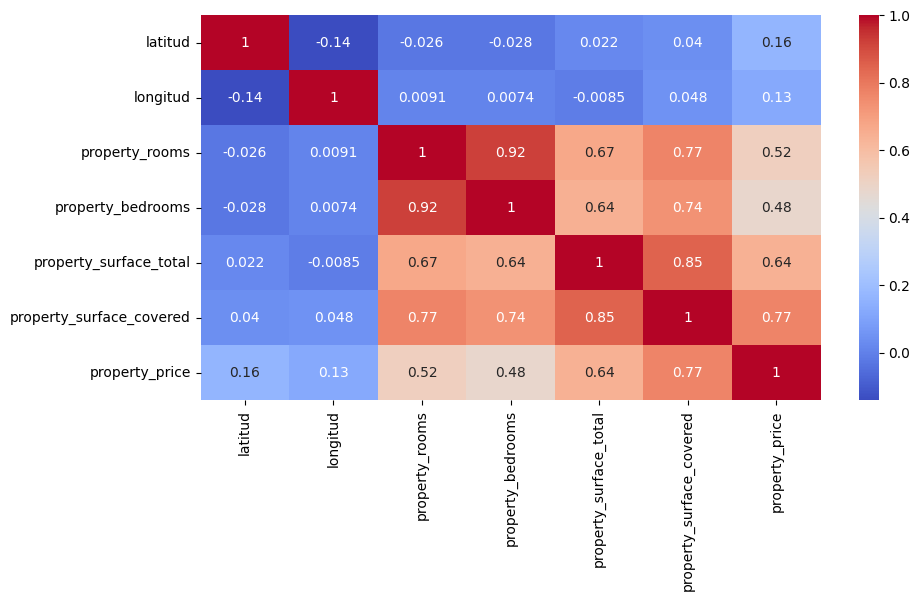

In [276]:
matriz_correlacion=viviendas_caba.corr()

plt.figure(figsize=(10,5))
sns.heatmap(matriz_correlacion, annot = True,cmap = 'coolwarm')
plt.show()

Vemos que es util utilizar PCA ya que tenemos variables correlacionadas.  
PCA es un procedimiento matemático por el cual se transforma un conjunto de variables correlacionadas en un conjunto de variables no correlacionadas de menor dimensión. Estas nuevas variables se obtiene a partir de combinaciones lineales de las variables originales. <br>
Estas nuevas variables son las que se denominan Componentes Principales.

Esta técnica intenta hallar aquellas combinaciones lineales de las variables originales que maximizan la varianza (minimizan la pérdida de información original).

Esta técnica no requiere supuestos por lo que puede aplicarse siempre (pero, ojo!, tendrá sentido si las variables originales están correlacionadas).

El objetivo es reducir la dimensión del problema, es decir, descartar la información redundante.

PCA ejecutado en 6 pasos:

Normalizar los atributos. <br>
Calcular la matriz de covarianza. <br>
Calcular autovalores y autovectores. <br>
Ordenar los autovalores por orden descendente para elegir las componentes a utilizar.<br>
Ordenar los autovectores en función del orden de los autovalores y armar la matriz de transformación.<br>

In [277]:
columnas_elegidas = ['property_rooms', 'property_bedrooms', 'property_surface_total', 'property_surface_covered', 'latitud', 'longitud']
x = viviendas_caba.loc[:, columnas_elegidas].values
x = StandardScaler().fit_transform(x)

In [278]:
pca = PCA(n_components=6, random_state=0)
x_transformada = pca.fit_transform(x)

pca_df_aux = pd.DataFrame(data = x_transformada, columns = ['cp_1', 'cp_2','cp_3','cp_4','cp_5','cp_6'])

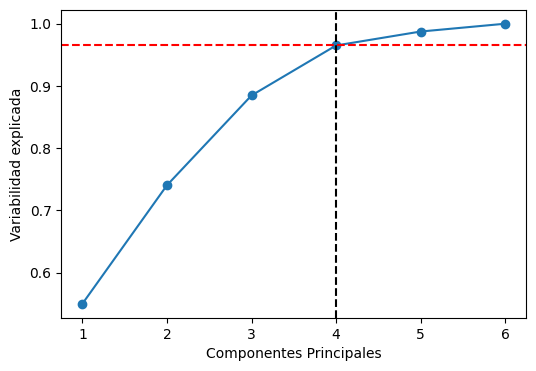

In [279]:
varianza_explicada = pca.explained_variance_ratio_
list_x = list(range(1, len(varianza_explicada)+1))

# Grafico Variabilidad explicada y cantidad de componentes principales
plt.figure(figsize=(6, 4))
plt.plot(list_x, varianza_explicada.cumsum(), '-o')
plt.xlabel(r'Componentes Principales')
plt.ylabel('Variabilidad explicada')
plt.axvline(x=4, color="k", linestyle="--")

plt.axhline(y=(pca.explained_variance_ratio_[0:4].sum()), color="r", linestyle="--")
plt.show()

Vemos que con las primeras 4 componentes principales ya explicamos más de un 95% de la variabilidad del dataset, por lo que nos guardamos la reduccion de dimensionalidad con solo esas 4 componentes principales.

In [280]:
pca_df_aux.drop(['cp_5','cp_6'], axis=1, inplace=True)
pca_df_aux['property_price'] = viviendas_caba.property_price.copy()
pca_df_aux.dropna(inplace=True)
pca_df_aux.to_csv('./Datasets/pca_properati_argentina_2021.csv', index = False)

### Guardado de archivos

In [281]:
viviendas_caba_train.to_csv('./Datasets/viviendas_caba_train.csv', index = False)
viviendas_caba_test.to_csv('./Datasets/viviendas_caba_test.csv', index = False)
viviendas_caba.to_csv('./Datasets/viviendas_caba.csv', index = False)